In [1]:
import pandas as pd
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import collections
import krippendorff_alpha as ka
import copy
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss
import pingouin as pg

In [2]:
def annotate_barplot(g, pad_x, pad_y=0, middle=20, perc=False, limit_to_half=False):
    for p in g.patches:
        width = p.get_width()
        x = (width + pad_x if width < middle else width - pad_x)
        if limit_to_half:
            x = min(x, g.get_xlim()[1]/2)
        g.text(x,
            p.get_y()+p.get_height()/2. + pad_y,
            '{:1.2f}'.format(width) + '%'*perc,
            ha="center")
        
def annotate_barplot2(g, pad_x, pad_y=0, perc=False):
    for p in g.patches:
        width = p.get_width()
        g.text(pad_x ,
                p.get_y()+p.get_height()/2. + pad_y,
                '{:1.2f}'.format(width) + '%'*perc,
                ha="center")
        
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

# Parsing answer data to a dataframe

In [3]:
""" Connect to MTurk and to the Mongodb database. Set the boolean below to TRUE to use the marketplace and to FALSE to use the sandbox (testing the HITs)"""

with open('./config/mongodb_credentials.json','r') as f:
    mongodb_credentials = json.load(f)

db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
db = db_client['wikidata']

In [4]:
answers_db = db.hit_results.find()
answers_list = []
for hit in answers_db:
    for answer in hit['answers']:
        for i in range(6):
            answers_list.append(
                {
                    'task_id': hit['_id'],
                    'batch_id': hit['batch_id'],
                    'type': hit['type'],
                    'language': hit['language'],
                    'timestamp': hit['timestamp'],
                    'taskSet_id': hit['taskSet_id'],
                    'worker_id' : answer['worker_id'],
                    'reference_id': hit['references'][i]['reference_id'],
                    'g_id': False if hit['references'][i]['g_id'] == 0 else True,
                    'outputs': answer['values']['outputs'][i],
                    'time': answer['values']['times'][i]/1000.0
                }
    )
len(answers_list)

7230

In [5]:
answers_df = pd.DataFrame(answers_list)
answers_df.head()

,task_id,batch_id,type,language,timestamp,taskSet_id,worker_id,reference_id,g_id,outputs,time
0,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,0ed3d3c3eee9921afc0c53e9c947a0bddcb193a6,True,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",142.978
1,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,eec01187c078f8e4994ae4edd38a7e8c1a300233,True,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",24.620
2,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,4a8c3ad951c2a2faccbde7f22421b25afbdd443c,False,"{'is_present': 0, 'difficulty': -1, 'reason': 4}",92.251
3,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,51c5020b94d008646058bbbe2c191f4eb0002609,False,"{'is_present': 1, 'difficulty': 0, 'reason': -1}",249.661
4,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,4df038777ecf889d12435ee1f8a42d4e72bfc9cd,False,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",102.974


In [6]:
answers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7230 entries, 0 to 7229
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   task_id       7230 non-null   object        
 1   batch_id      7230 non-null   object        
 2   type          7230 non-null   object        
 3   language      7230 non-null   object        
 4   timestamp     7230 non-null   datetime64[ns]
 5   taskSet_id    7230 non-null   object        
 6   worker_id     7230 non-null   object        
 7   reference_id  7230 non-null   object        
 8   g_id          7230 non-null   bool          
 9   outputs       7230 non-null   object        
 10  time          7230 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(8)
memory usage: 572.0+ KB


# Analyzing the whole dataframe first (both types, all languages)

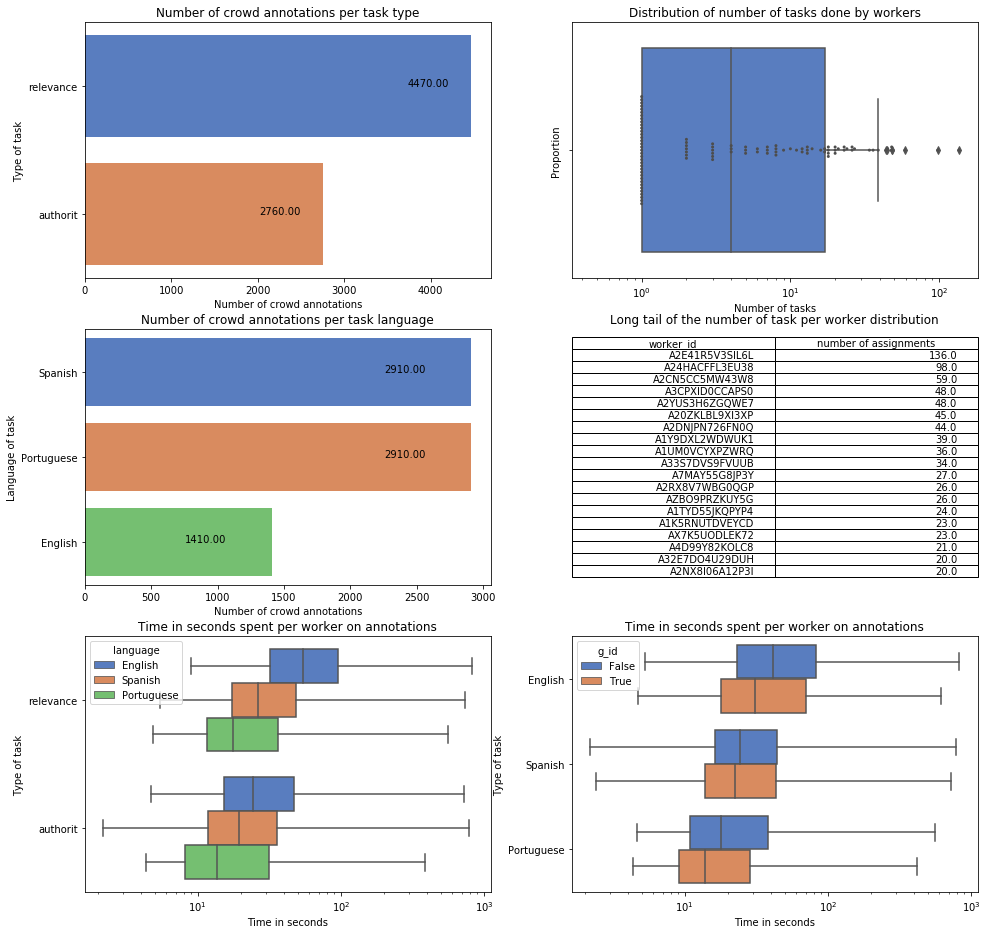

Worker's contribution median: 4.0
Mean time spent per worker in seconds was 41.13671507607203, which according to USD 7.25 for minimum wage should be rewarded tiwh USD 0.4970686405025371


In [7]:
sns.set_palette('muted')
fig, ax = plt.subplots(3,2,figsize = (16,16))

g = sns.barplot(data=answers_df['type'].value_counts().reset_index(),x='type',y='index', ax=ax[0,0])
annotate_barplot(g, pad_x = 500)
ax[0,0].set(title='Number of crowd annotations per task type',
      ylabel='Type of task',
      xlabel = 'Number of crowd annotations')

g = sns.barplot(data=answers_df['language'].value_counts().reset_index(),x='language',y='index', ax=ax[1,0])
annotate_barplot(g, pad_x = 500)
ax[1,0].set(title='Number of crowd annotations per task language',
      ylabel='Language of task',
      xlabel = 'Number of crowd annotations')

g = sns.boxplot(answers_df['worker_id'].value_counts()/6, ax=ax[0,1])
g = sns.swarmplot(answers_df['worker_id'].value_counts()/6, ax=ax[0,1],size=3, color=".3", linewidth=0)
ax[0,1].set_xscale("log")
ax[0,1].set(title='Distribution of number of tasks done by workers',
      xlabel='Number of tasks',
      ylabel = 'Proportion')

worker_count_df = (answers_df['worker_id'].value_counts()/6).reset_index().head(19)
worker_count_df.columns = ['worker_id', 'number of assignments']
ax[1,1].table(cellText=worker_count_df.values, colLabels=worker_count_df.columns, loc='center')
ax[1,1].axis('off')
ax[1,1].axis('tight')
ax[1,1].set(
    title = 'Long tail of the number of task per worker distribution'
)

ax[2,0].set_xscale("log")
g = sns.boxplot(x="time", y="type", hue='language', data=answers_df,
            whis=[0, 100], ax=ax[2,0])
ax[2,0].set(title='Time in seconds spent per worker on annotations',
      xlabel='Time in seconds',
      ylabel = 'Type of task')

ax[2,1].set_xscale("log")
g = sns.boxplot(x="time", hue="g_id", y='language', data=answers_df,
            whis=[0, 100], ax=ax[2,1])
ax[2,1].set(title='Time in seconds spent per worker on annotations',
      xlabel='Time in seconds',
      ylabel = 'Type of task')


plt.show()
print('Worker\'s contribution median:',np.median(answers_df['worker_id'].value_counts()/6))
print('Mean time spent per worker in seconds was {}, which according \
to USD 7.25 for minimum wage should be rewarded tiwh USD {}'.\
        format(np.mean(answers_df['time']),6*np.mean(answers_df['time'])/60*7.25/60))

# Separating task type results

In [8]:
answers_rel_df = answers_df[answers_df['type'] == 'relevance']
answers_rel_outputs = pd.DataFrame(answers_rel_df['outputs'].tolist(), index=answers_rel_df['outputs'].index)
answers_rel_df = answers_rel_df.join(answers_rel_outputs)

answers_auth_df = answers_df[answers_df['type'] == 'authorit']
answers_auth_outputs = pd.DataFrame(answers_auth_df['outputs'].tolist(), index=answers_auth_df['outputs'].index)
answers_auth_df = answers_auth_df.join(answers_auth_outputs)

# Relevancy results analysis

In [9]:
answers_rel_df.head()

,task_id,batch_id,type,language,timestamp,taskSet_id,worker_id,reference_id,g_id,outputs,time,is_present,difficulty,reason
0,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,0ed3d3c3eee9921afc0c53e9c947a0bddcb193a6,True,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",142.978,1,3,-1
1,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,eec01187c078f8e4994ae4edd38a7e8c1a300233,True,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",24.620,1,3,-1
2,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,4a8c3ad951c2a2faccbde7f22421b25afbdd443c,False,"{'is_present': 0, 'difficulty': -1, 'reason': 4}",92.251,0,-1,4
3,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,51c5020b94d008646058bbbe2c191f4eb0002609,False,"{'is_present': 1, 'difficulty': 0, 'reason': -1}",249.661,1,0,-1
4,37YYO3NWIG29W4ERVUN2T145LHTCCA,234996d5-094f-4f44-94c2-36accab5c074,relevance,English,2020-06-15 21:32:02.981,cc761048-bb6b-40d5-9a1a-a3e75cee9b43,A24HACFFL3EU38,4df038777ecf889d12435ee1f8a42d4e72bfc9cd,False,"{'is_present': 1, 'difficulty': 3, 'reason': -1}",102.974,1,3,-1


## Distribution of annotations (not aggregated)

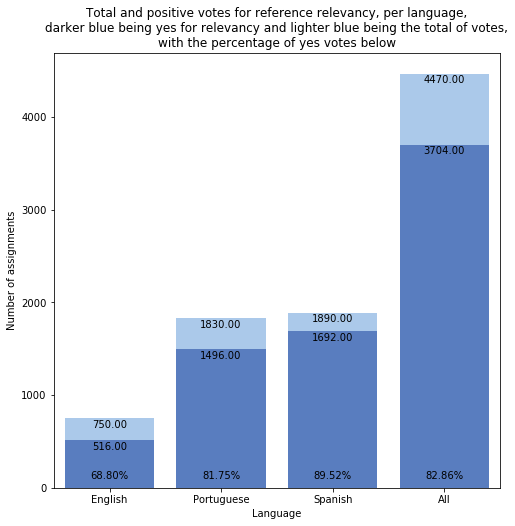

In [10]:
fig, ax = plt.subplots(figsize=(8,8))

answers_rel_language_is_present = answers_rel_df[['language','is_present']]\
            .groupby(['language'])\
            .sum()\
            .join(answers_rel_df['language'].value_counts())
answers_rel_language_is_present.columns = ['is_present','total']
answers_rel_language_is_present['per'] =\
    answers_rel_language_is_present.apply(lambda x: 100*x['is_present']/x['total'], axis=1)
answers_rel_language_is_present = answers_rel_language_is_present.reset_index()

answers_rel_language_is_present = answers_rel_language_is_present.append(
    {
        'language':'All',
         'is_present': answers_rel_language_is_present['is_present'].sum(),
        'total': answers_rel_language_is_present['total'].sum(),
        'per': 100*answers_rel_language_is_present['is_present'].sum()/answers_rel_language_is_present['total'].sum()
    }, ignore_index=True
)

sns.set_color_codes("pastel")
g = sns.barplot(x="language", y="total",
            data=answers_rel_language_is_present,
            color="b", ax=ax)

sns.set_color_codes("muted")
g = sns.barplot(x="language", y="is_present",
            data=answers_rel_language_is_present,
            color="b", ax=ax)

for i, p in enumerate(g.patches):
    height = p.get_height()
    width = p.get_width()
    g.text(i%4,
            height-100,
            '{:1.2f}'.format(height),
            ha="center")
for i in range(4):
    g.text(i,
            100,
            '{:1.2f}%'.format(answers_rel_language_is_present.loc[i,'per']),
            ha="center")

ax.set(title='Total and positive votes for reference relevancy, per language,\ndarker blue being yes for relevancy and lighter blue being the total of votes,\nwith the percentage of yes votes below',
       xlabel='Language', ylabel = 'Number of assignments')

plt.show()

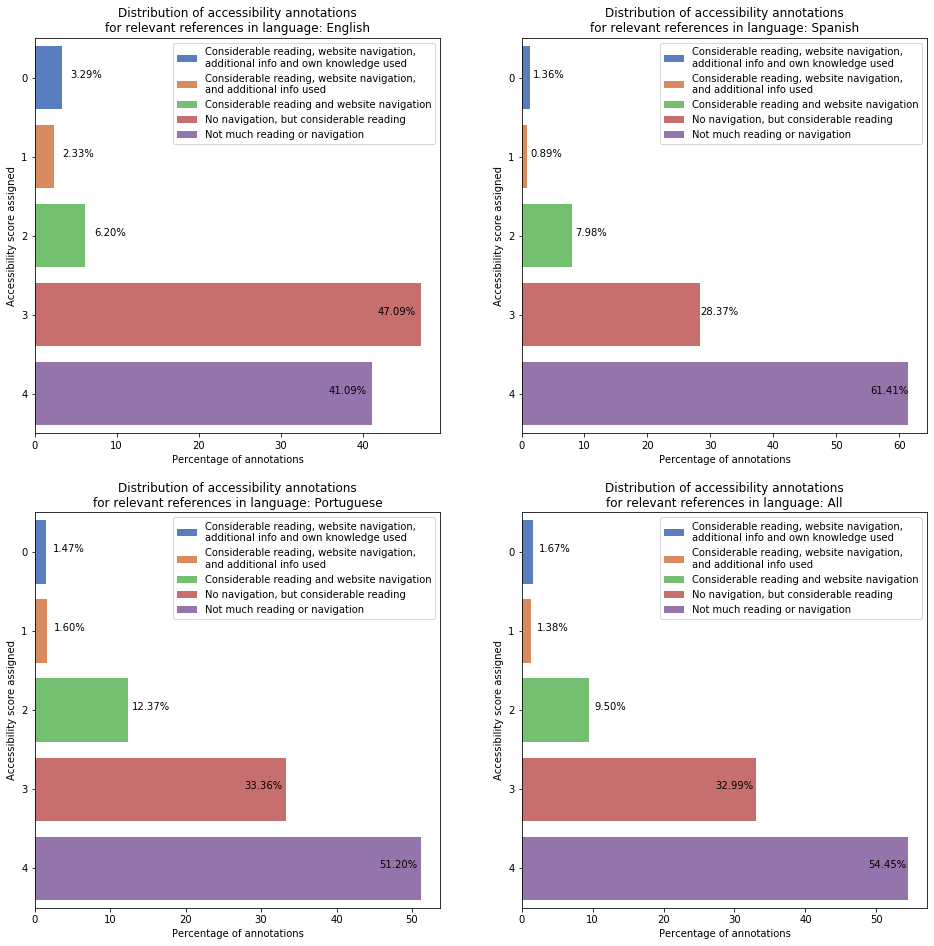

In [11]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_rel_df['language'].unique()) + ['All']):
    answers_rel_df_lan = answers_rel_df.copy()
    if language != 'All':
        answers_rel_df_lan = answers_rel_df_lan[answers_rel_df_lan['language'] == language]
    
    answers_rel_language_difficulty =\
        answers_rel_df_lan[answers_rel_df_lan['is_present'] == 1]['difficulty'].value_counts().reset_index()
    answers_rel_language_difficulty['per'] =\
        100*answers_rel_language_difficulty['difficulty']/sum(answers_rel_language_difficulty['difficulty'])

    g = sns.barplot(
        data = answers_rel_language_difficulty,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 3, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of accessibility annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Accessibility score assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Considerable reading, website navigation,\nadditional info and own knowledge used',
        'Considerable reading, website navigation,\nand additional info used',
        'Considerable reading and website navigation',
        'No navigation, but considerable reading',
        'Not much reading or navigation'
    ])

plt.show()

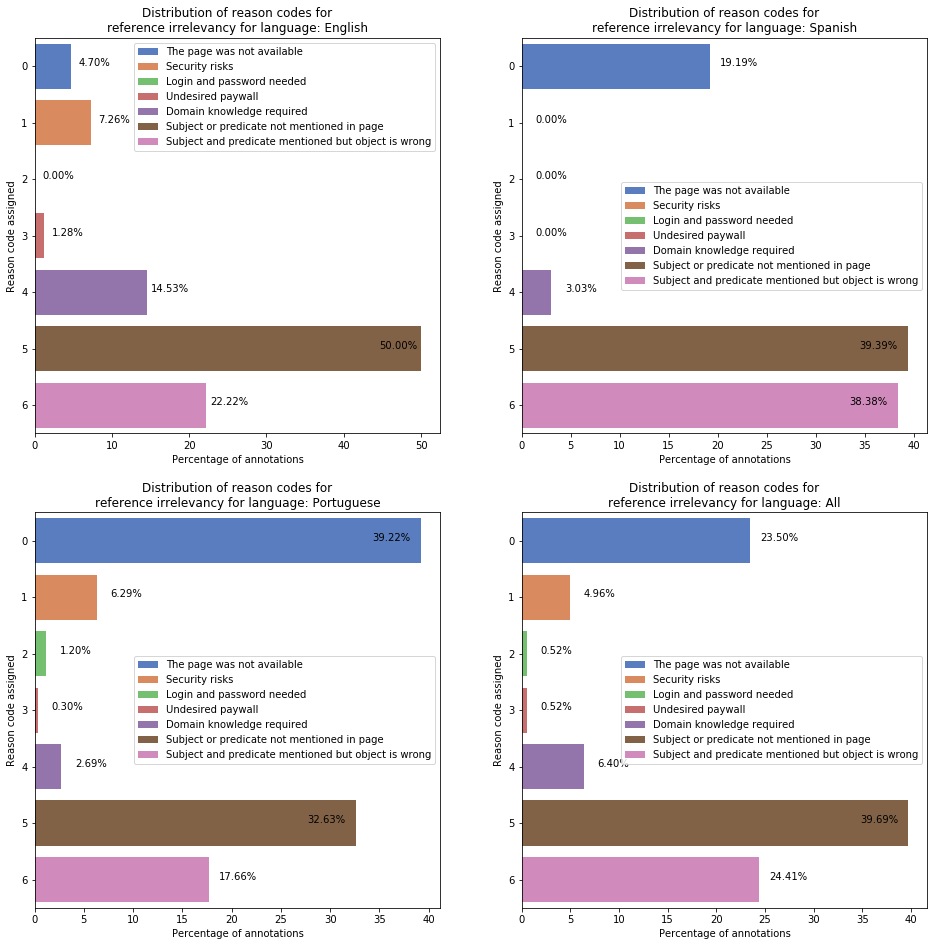

In [12]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_rel_df['language'].unique()) + ['All']):
    answers_rel_df_lan = answers_rel_df.copy()
    if language != 'All':
        answers_rel_df_lan = answers_rel_df_lan[answers_rel_df_lan['language'] == language]
    
    answers_rel_language_reason =\
        answers_rel_df_lan[answers_rel_df_lan['is_present'] == 0]['reason'].value_counts().reset_index()
    answers_rel_language_reason['per'] =\
        100*answers_rel_language_reason['reason']/sum(answers_rel_language_reason['reason'])
    
    for j in range(7):
        if j not in answers_rel_language_reason['index'].values:
            answers_rel_language_reason = answers_rel_language_reason.append(
                {'index':j,'reason':0,'per':0}, ignore_index=True
            )

    g = sns.barplot(
        data = answers_rel_language_reason,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    annotate_barplot(g, pad_x = 3, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of reason codes for\nreference irrelevancy for language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Reason code assigned'
    )
    
    ax[i//2,i%2].legend(
        handles=ax[i//2,i%2].patches,
        labels=[
            'The page was not available',
            'Security risks',
            'Login and password needed',
            'Undesired paywall',
            'Domain knowledge required',
            'Subject or predicate not mentioned in page',
            'Subject and predicate mentioned but object is wrong'
        ],
        loc = 'best'
    )

plt.show()

## Annotator agreement levels

We set a threshold to exclude too biased workers towards yes and no. We vary these thresholds to see how agreement behaves. What we see is that the more we exclude workers, the more the agreement tends to grows.
This growth, however, does not necessarily showcase an improvement in the quality of annotation, as this may be just an unnatural inflation of the metric.

As Beyari et al. cites in [this paper](https://www.aclweb.org/anthology/J11-4004.pdf):

    That two coders agree more often than groups of four or more points to the fact that small groups may simply not represent the full spectrum of possible disagreements. Two annotators may well agree with each other by chance. This chance decreases, however, the more annotators get involved, as with rising coder numbers the probability of biases or disparate interpretations of language material increases dramatically.
    
They show that more annotators leads to less agreement naturally (β=−0.09, p<0.05,k=334).
We have varied _thr_up_ and _thr_down_ separately until agreement could not be calculated and computed the following graphs.
As we are not sure whether these increases are due to agreement being statistically more likely or because bad workers are weeded out, and because we already employ anti-spammer measures and golden standards, we decided to include all contributions that made it this far.

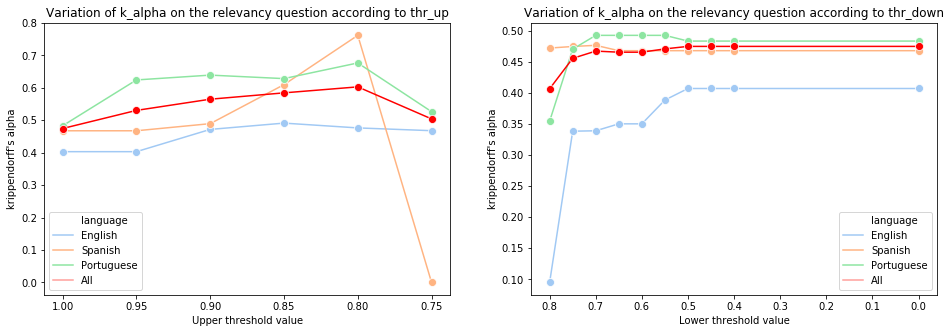

In [13]:
thr_up_data = pd.read_csv('worker_aggreement_varying_upper_bound.csv')

fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.set_palette("pastel")

g = sns.lineplot(x="thr_up", y="k_alpha",
            hue="language", marker='o', dashes=False,sizes=(.25, 2.5),
            legend="full", data=thr_up_data, ax=ax[0], markersize=8)
ax[0].set_xlim(ax[0].get_xlim()[::-1])
regline = g.get_lines()[3]
regline.set_color('red')
ax[0].set(title='Variation of k_alpha on the relevancy question according to thr_up', 
          xlabel='Upper threshold value', ylabel='krippendorff\'s alpha')


thr_down_data = pd.read_csv('worker_aggreement_varying_lower_bound.csv')

g = sns.lineplot(x="thr_down", y="k_alpha",
            hue="language", marker='o', dashes=False,sizes=(.25, 2.5),
            legend="full", data=thr_down_data, ax=ax[1], markersize=8)
ax[1].set_xlim(ax[1].get_xlim()[::-1])
regline = g.get_lines()[3]
regline.set_color('red')
ax[1].set(title='Variation of k_alpha on the relevancy question according to thr_down', 
          xlabel='Lower threshold value', ylabel='krippendorff\'s alpha')


plt.show()

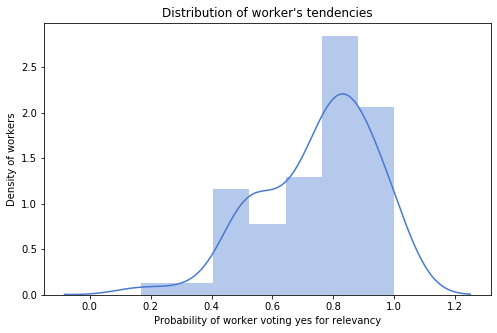

In [14]:
thr_up = 1
thr_down = 0

workers = []
for worker in answers_rel_df['worker_id'].unique():
    is_present_list = []
    for i, row in answers_rel_df[answers_rel_df['worker_id'] == worker].iterrows():
        is_present_list.append(row['is_present'])
    workers.append({
        'worker' : worker,
        'task_count' : len(is_present_list),
        'yes_percentage' : sum(is_present_list)/len(is_present_list)
    })
workers_tendency = pd.DataFrame(workers).sort_values('task_count', ascending=False).reset_index(drop=True)

bad_workers = workers_tendency[
    workers_tendency['yes_percentage'].apply(lambda x : x > thr_up or x < thr_down)
]['worker'].unique()

sns.set_palette('muted')
fig, ax = plt.subplots(figsize=(8,5))

sns.distplot(workers_tendency['yes_percentage'], ax=ax)
ax.set(title='Distribution of worker\'s tendencies',
      xlabel = 'Probability of worker voting yes for relevancy',
      ylabel = 'Density of workers')

plt.show()

In [15]:
answers_rel_worker_outputs_df = answers_rel_df[['worker_id','reference_id','language','g_id','is_present','difficulty','reason']]
answers_rel_worker_outputs_df =\
    answers_rel_worker_outputs_df[
        answers_rel_worker_outputs_df['worker_id'].apply(
            lambda x : x not in bad_workers)
    ]

In [16]:
answers_rel_worker_outputs_df

,worker_id,reference_id,language,g_id,is_present,difficulty,reason
0,A24HACFFL3EU38,0ed3d3c3eee9921afc0c53e9c947a0bddcb193a6,English,True,1,3,-1
1,A24HACFFL3EU38,eec01187c078f8e4994ae4edd38a7e8c1a300233,English,True,1,3,-1
2,A24HACFFL3EU38,4a8c3ad951c2a2faccbde7f22421b25afbdd443c,English,False,0,-1,4
3,A24HACFFL3EU38,51c5020b94d008646058bbbe2c191f4eb0002609,English,False,1,0,-1
4,A24HACFFL3EU38,4df038777ecf889d12435ee1f8a42d4e72bfc9cd,English,False,1,3,-1
...,...,...,...,...,...,...,...
7225,A2DNJPN726FN0Q,10097e4e159c9de218d4d4196e1fea40eeb83401,Portuguese,False,1,3,-1
7226,A2DNJPN726FN0Q,b450d720025dbbb2d148dce633280b921bfe3a2f,Portuguese,False,1,4,-1
7227,A2DNJPN726FN0Q,37a162a128e499e5c9fa2a045f034e447972bfe9,Portuguese,True,0,-1,5
7228,A2DNJPN726FN0Q,90ade927cfa604f29a6a2e3782ba73d9ac72a8a8,Portuguese,True,1,3,-1


In [17]:
def prep_for_kripp(df,col,language=None, fun=np.max):
    '''
    WE TAKE THE MAX HERE. I HAVE ANALYSED THE CASES WHERE THE SAME AUTHOR RATES A REFERENCE TWO WAYS AND, NOT ONLY
    THEY ARE VERY FEW, BUT THE INFORMATION IS ALWAYS THERE, SO IT IS PROBABLY THE CASE THAT THEY MISSED THIS INFOR-
    MATION AT FIRST BUT THEN IDENTIFIED IT, OR IDENTIFIED IT AT FIRST BUT GOT LESS ACTIVE/PATIENT FURTHER ON
    '''
    df = df.copy()
    if language:
        df = df[df['language'] == language]
    df = df[['worker_id','reference_id',col]].groupby(['worker_id','reference_id']).agg(fun).reset_index()
    df = df.pivot(index='worker_id',columns='reference_id',values=col).fillna('*')
    return df

def prep_for_fleiss(df, col, language=None):
    df = df.copy()
    if language:
        df = df[df['language'] == language]    
    df = df[['reference_id',col]]
    df['count'] = 1
    df = df.groupby(['reference_id',col]).sum().reset_index()
    df = df.pivot(index='reference_id', columns=col, values='count').fillna(0)
    df = df[df.apply(lambda x : sum(x) == 5.0, axis=1)]
    return df

def prep_for_icc(df, language=None):
    df = df.copy()
    if language:
        df = df[df['language'] == language]    
    ref_count = df['reference_id'].value_counts().reset_index()
    not_repeated = list(ref_count[ref_count['reference_id'] == 5]['index'])

    df = df[df['reference_id'].apply(lambda x : x in not_repeated)]
    df = df.sort_values('reference_id')
    df['raters'] = ['A','B','C','D','E']*(df.shape[0]//5)
    return df

aggr_levels_relevancy = {}

To help interpret these results, refer to this table, found here (I checked those refs except for Cicchetti & Sparrow):
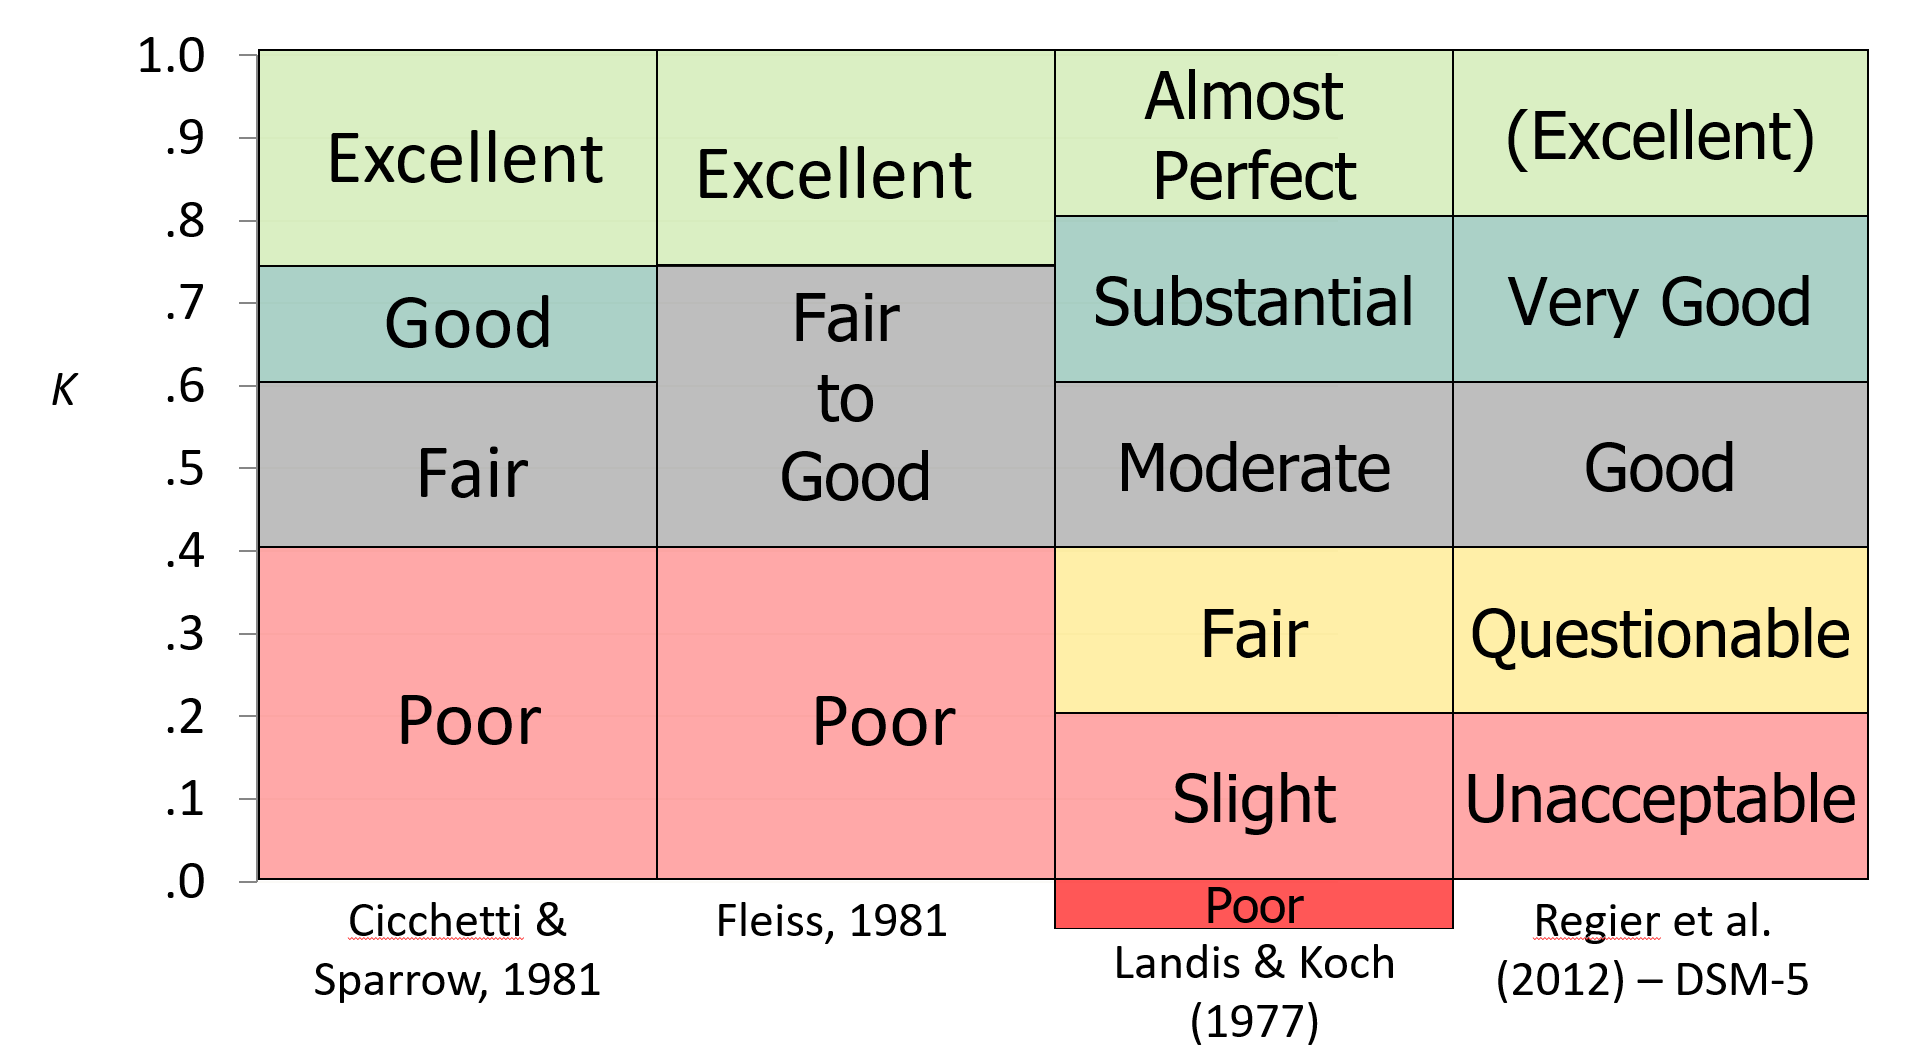
This table is for Kappa values, but Krippendorff's alpha is a generalization of Kappa measures (and other measures). Also, these values can be used as a rule of thumb for Krippendorff as well, as Krippendorff's original and more conservative cuttoffs are based on his own work and are noted by himself to not be applicable to other methods and research questions necessarily.

As for ICCs, we have:

[Cicchetti (1994)](https://psycnet.apa.org/doiLanding?doi=10.1037%2F1040-3590.6.4.284) gives the following often quoted guidelines for interpretation for kappa or ICC inter-rater agreement measures:

    Less than 0.40—poor.
    Between 0.40 and 0.59—fair.
    Between 0.60 and 0.74—good.
    Between 0.75 and 1.00—excellent.

A different guideline is given by [Koo and Li (2016)](https://linkinghub.elsevier.com/retrieve/pii/S1556370716000158)

    below 0.50: poor
    between 0.50 and 0.75: moderate
    between 0.75 and 0.90: good
    above 0.90: excellent
    
We choose ICC(1,1), as ICC (intra-class correlation coefficient) method, as per [Koo and Li](https://linkinghub.elsevier.com/retrieve/pii/S1556370716000158).

### is_present
This is nominal, so we can use Kripp and Kappa measures

In [18]:
aggr_levels_relevancy['is_present'] = {}
aggr_levels_relevancy['is_present']['kalpha'] = {}

for language in list(answers_rel_worker_outputs_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_rel_worker_outputs_df,'is_present',language=language
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.nominal_metric, missing_items='*')
        aggr_levels_relevancy['is_present']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for relevancy in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception as e:
        print('Error {}'.format(language), e)

Krippendorff's alpha for relevancy in language English is 0.40323454484674526
Krippendorff's alpha for relevancy in language Spanish is 0.4676754015215555
Krippendorff's alpha for relevancy in language Portuguese is 0.48313393061184207
Krippendorff's alpha for relevancy in language None is 0.47466712967482916


Krippendorff's alpha is a generalization of Fleiss' Kappa and other measures. You can also see a more in-depth comparison between respective values here: https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-016-0200-9

However, the annotators in this study have no prior information about class distributions, so they need a free-margin kappa (https://journals.sagepub.com/doi/10.1177/001316448104100307). Using a fixed-margin kappa suchas Fleiss' may cause the high agreement low kappa paradox (https://www.sciencedirect.com/science/article/pii/089543569090158L). Here, as in the papers, fixed-margin means that the Kappa formula takes into account the distribution of subjects to be rated across the possible classes, and it tends to give very low numbers even though agreement is high in the case where the distribution is too skewed towards one class. Margin-free means that the Kappa formula makes no assumption as to the distribution. For more info, see the cases of Tables 1 and 2 in the paper https://www.sciencedirect.com/science/article/pii/089543569090158L and also in http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.8776&rep=rep1&type=pdf. Hence we use Randolph's Kappa (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.8776&rep=rep1&type=pdf).

In [19]:
aggr_levels_relevancy['is_present']['fkappa'] = {}

for language in list(answers_rel_worker_outputs_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_rel_worker_outputs_df,'is_present',language=language
    )
    fkappa = fleiss(df_fleiss)
    aggr_levels_relevancy['is_present']['fkappa'][language] = fkappa
    print('Fleiss\'s kappa for relevancy in language {} is {}'.format(
        language,
        fkappa
    ))

Fleiss's kappa for relevancy in language English is 0.3280388743835216
Fleiss's kappa for relevancy in language Spanish is 0.44017587996645596
Fleiss's kappa for relevancy in language Portuguese is 0.45962501914283876
Fleiss's kappa for relevancy in language None is 0.43386649969641794


In [20]:
aggr_levels_relevancy['is_present']['rkappa'] = {}

for language in list(answers_rel_worker_outputs_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_rel_worker_outputs_df,'is_present',language=language
    )
    rkappa = fleiss(df_fleiss, method = 'rand')
    aggr_levels_relevancy['is_present']['rkappa'][language] = rkappa
    print('Randolph\'s kappa for relevancy in language {} is {}'.format(
        language,
        rkappa
    ))

Randolph's kappa for relevancy in language English is 0.43853211009174276
Randolph's kappa for relevancy in language Spanish is 0.7661538461538462
Randolph's kappa for relevancy in language Portuguese is 0.7408906882591093
Randolph's kappa for relevancy in language None is 0.698051948051948


### difficulty / accessibility

We check on workers who gave different votes for the same reference (which tends to happen to golden standard or to tasks that were caught by the same worker if they were relaunched (very few cases). This happens, as mentioned, because as they do it again they may be doing _better_ , as they have done multiple tasks and have experience, or _worse_ , if they are tired or grew uninterested or are doing the work a bit mindlesly.

That accounts for 3.8% of assignments.

We see that most repeated assignment values tend to stay within 1 level of distance from each other. Some values are a -1 among other non-negative values, indicating that the worker did not find it once but then found it later on another try.

In fact, 70% of the repetitions occur within 1 level of distance, 6% within 2 levels and 18% are a not_relevant (-1) and relevant (0-4) score.

So we have decided to take the mean for these repetitions as the final value, considering that accessibility here is on an interval scale.

As this is interval data, we can use **Kripp** and an **ICC** (ICC(1,1) for this, as discussed)

In [21]:
repeated_difficulty = answers_rel_worker_outputs_df[['worker_id','reference_id','difficulty']].drop_duplicates().reset_index(drop=True)
repeated_difficulty['difficulty'] = repeated_difficulty['difficulty'].apply(lambda x : [x])
repeated_difficulty = repeated_difficulty.groupby(['worker_id','reference_id']).sum().reset_index()
total_assignments = repeated_difficulty.shape[0]

repeated_difficulty = repeated_difficulty[repeated_difficulty['difficulty'].apply(lambda x : len(x) > 1)]
print('Total percentage of assignments that are repeated: {:1.2f}%'.format(100*repeated_difficulty.shape[0]/total_assignments))

repeated_difficulty = repeated_difficulty['difficulty'].value_counts()
print('Frequenty of values given to repeated assignments')
print(repeated_difficulty)
print('Total number of repeated assignments')
print(repeated_difficulty.sum())

Total percentage of assignments that are repeated: 3.80%
Frequenty of values given to repeated assignments
[3, 4]        34
[4, 3]        33
[3, 2]        11
[-1, 3]        9
[2, 3]         9
[1, 2]         7
[3, -1]        5
[-1, 4]        4
[2, 4]         3
[-1, 2]        3
[1, 3]         2
[4, -1]        2
[0, 2]         1
[-1, 0]        1
[2, -1, 1]     1
[0, -1]        1
[0, -1, 3]     1
[3, 0]         1
[4, 2]         1
[-1, 1, 2]     1
[4, 2, 3]      1
[2, 0]         1
[0, 2, 3]      1
[1, 0]         1
[3, 4, 2]      1
Name: difficulty, dtype: int64
Total number of repeated assignments
135


As this data is thus interval, we run the krippendorff's alpha differently.

In [22]:
aggr_levels_relevancy['difficulty'] = {}
aggr_levels_relevancy['difficulty']['kalpha'] = {}

for language in list(answers_rel_worker_outputs_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_rel_worker_outputs_df,'difficulty',language=language,fun=np.mean
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.interval_metric, missing_items='*')
        aggr_levels_relevancy['difficulty']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for difficulty/accessibility in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception:
        print('Error {}'.format(language))

Krippendorff's alpha for difficulty/accessibility in language English is 0.4180534385028799
Krippendorff's alpha for difficulty/accessibility in language Spanish is 0.6028388099309145
Krippendorff's alpha for difficulty/accessibility in language Portuguese is 0.5698970479405107
Krippendorff's alpha for difficulty/accessibility in language None is 0.5606622097305656


Fleiss' Kappa is not made for interval data, but for nominal and ordinal data, so it won't perfectly reflect our agreement measures. We're looking for another measure.

In [23]:
aggr_levels_relevancy['difficulty']['icc'] = {}

for language in list(answers_rel_worker_outputs_df['language'].unique()) + [None]:
    df_icc = prep_for_icc(
        answers_rel_worker_outputs_df,language=language
    )
    try:
        icc = pg.intraclass_corr(data = df_icc, targets = 'reference_id',raters='raters',ratings='difficulty')
        aggr_levels_relevancy['difficulty']['icc'][language] = icc.loc[0,'ICC']
        print('ICC for accessibility in language {} is:'.format(language))
        print(pg.intraclass_corr(data = df_icc, targets = 'reference_id',raters='raters',ratings='difficulty'))
    except Exception as e:
        print('Error {}'.format(language), e)

ICC for accessibility in language English is:
    Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.369318  3.927929  108  436  2.913929e-24   
1   ICC2     Single random raters  0.369761  3.949929  108  432  2.234811e-24   
2   ICC3      Single fixed raters  0.371064  3.949929  108  432  2.234811e-24   
3  ICC1k  Average raters absolute  0.745413  3.927929  108  436  2.913929e-24   
4  ICC2k    Average random raters  0.745773  3.949929  108  432  2.234811e-24   
5  ICC3k     Average fixed raters  0.746831  3.949929  108  432  2.234811e-24   

          CI95%  
0  [0.28, 0.47]  
1  [0.28, 0.47]  
2  [0.28, 0.47]  
3  [0.66, 0.81]  
4  [0.66, 0.81]  
5  [0.66, 0.81]  
ICC for accessibility in language Spanish is:
    Type              Description       ICC         F  df1   df2  \
0   ICC1   Single raters absolute  0.568970  7.600111  259  1040   
1   ICC2     Single random raters  0.568886  7.583123  259  1036   
2   ICC3  

### reason

We check on workers who gave different votes for the same reference (which tends to happen to golden standard or to tasks that were caught by the same worker if they were relaunched (very few cases). This happens, as mentioned, because as they do it again they may be doing _better_ , as they have done multiple tasks and have experience, or _worse_ , if they are tired or grew uninterested or are doing the work a bit mindlesly.

That accounts for 1.13% of assignments.

We see that most repeated assignment values tend to be a 'reason' class confused with a -1, indicating that most cases are of people who got did not find the reference, but then did (or vice-versa) for the reasons explained above.

In fact, 52.5% of repetitions are between 6 or 5 (subject or predicate not present or wrong object) and -1 (relevant), which indicates a person not finding the correct information in a working and understandable page, but then finding it. Including these 52.5%, a total of 77.5% of repetitions are between a non-relevancy code and -1 (relevancy), indicating that over 3/4 of cases are of someone not finding the information for any reason, but then finding it. All other cases (remaining 22.5%) are either :
- 10%: people labeling as both 5 (subject or predicate not present) and 0 (page not working), which indicate that on one of the tries, the page did not work.
- 7.5%: people labeling as both 5 (subject or predicate not present) and 6 (wrong object), which are similar in the sense that both report on the ability of the person to find the information;
- 5%: people labeling as both 5 (subject or predicate not present) and 4 (domain knowledge required), which indicate that people first tried to analyse the reference and failed but on a second time just regarded it as needing domain knowledge (or the opposite order);

Every remaining combination was not found on the repeated set, which is a good sign. Repetitions of the like  4(domain knowledge) and 2 (login needed) would be harder to contextualize, as it requires the person to then just happen to have a login and password they forgot existed. 2 (login) and 3 (paywall) would be even weirder, as it would indicate that a website has both a login barrier and a payment barrier, and that the user faced both at different scenarios.

So we have decided to take all repetitions into account, by counting them as done by an additional worker.

As this is nominal data, we can use **Kripp** and an **Kappas**

In [24]:
repeated_reason = answers_rel_worker_outputs_df[['worker_id','reference_id','reason']].drop_duplicates().reset_index(drop=True)
repeated_reason['reason'] = repeated_reason['reason'].apply(lambda x : [x])
repeated_reason = repeated_reason.groupby(['worker_id','reference_id']).sum().reset_index()
total_assignments = repeated_reason.shape[0]

repeated_reason = repeated_reason[repeated_reason['reason'].apply(lambda x : len(x) > 1)]
print('Total percentage of assignments that are repeated: {:1.2f}%'.format(100*repeated_reason.shape[0]/total_assignments))

repeated_reason = repeated_reason['reason'].value_counts()
print('Frequenty of values given to repeated assignments')
print(repeated_reason)
print('Total number of repeated assignments')
print(repeated_reason.sum())

Total percentage of assignments that are repeated: 1.13%
Frequenty of values given to repeated assignments
[5, -1]       9
[-1, 5]       6
[0, -1]       4
[-1, 6]       3
[-1, 0]       3
[6, -1]       3
[5, 0]        2
[4, -1]       2
[4, 5]        2
[5, 0, -1]    1
[5, -1, 6]    1
[0, 5]        1
[5, 6]        1
[6, 5]        1
[1, -1]       1
Name: reason, dtype: int64
Total number of repeated assignments
40


In [25]:
answers_rel_reason_df = answers_rel_worker_outputs_df.drop(['is_present','difficulty'],axis=1)
answers_rel_reason_df = answers_rel_reason_df.sort_values(['worker_id','reference_id']).reset_index(drop=True)
answers_rel_reason_df = answers_rel_reason_df[answers_rel_reason_df['reason'] != -1]

answers_rel_reason_withreps_df = answers_rel_reason_df.copy()
past_w, past_r, j = 'None', 'None', 0
for i, r in answers_rel_reason_withreps_df.iterrows():
    #print(r['worker_id'],past_w,r['reference_id'],past_r)
    if r['worker_id'] == past_w and r['reference_id'] == past_r:
        j += 1
        answers_rel_reason_withreps_df.loc[i,'worker_id'] = r['worker_id']+'_'+str(j)
    else:
        past_w, past_r, j = r['worker_id'], r['reference_id'], 0

answers_rel_reason_withreps_df

,worker_id,reference_id,language,g_id,reason
27,A10RGC1CJEMDAL,da5be3f9b27fbd29a226c1a8692f05fa3c485b83,Spanish,True,5
28,A10RGC1CJEMDAL_1,da5be3f9b27fbd29a226c1a8692f05fa3c485b83,Spanish,True,5
65,A1K5RNUTDVEYCD,616b11e141e33880150d7e17ec4f6be30ca23581,Portuguese,False,6
100,A1K5RNUTDVEYCD,ba45a2f27eeaeed0870378a86f8ec39ed0829912,Portuguese,False,6
109,A1K5RNUTDVEYCD,d0b6df71e9b52219703cc1700bd2eaecb88b38b3,Portuguese,True,6
...,...,...,...,...,...
4462,AZ1KTVBLOCNMM,d42dc4bad81c516fa6f5aab2bcf925ab108a3a30,English,True,4
4463,AZ1KTVBLOCNMM,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,False,5
4465,AZU9K0FD5U826,4c7031eb73301ecb969c8315aac1fce86585d26a,English,True,4
4467,AZU9K0FD5U826,6275dffd81835a0c6ef3bee49337a95b7235ae65,English,False,5


In [26]:
aggr_levels_relevancy['reason'] = {}
aggr_levels_relevancy['reason']['kalpha'] = {}

for language in list(answers_rel_reason_withreps_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_rel_reason_withreps_df,'reason',language=language,fun=np.mean
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.nominal_metric, missing_items='*')
        aggr_levels_relevancy['reason']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for reason in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception:
        print('Error {}'.format(language))

Krippendorff's alpha for reason in language Spanish is 0.5427602035724979
Krippendorff's alpha for reason in language Portuguese is 0.24991894638840384
Krippendorff's alpha for reason in language English is 0.27764503155625
Krippendorff's alpha for reason in language None is 0.3604510193096917


In [27]:
aggr_levels_relevancy['reason']['fkappa'] = {}

for language in list(answers_rel_reason_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_rel_reason_withreps_df,'reason',language=language
    )
    fkappa = fleiss(df_fleiss)
    aggr_levels_relevancy['reason']['fkappa'][language] = fkappa
    print('Fleiss\'s kappa for reason in language {} is {}'.format(
        language,
        fkappa
    ))
    
# MAYBE DO NOT REPORT THESE =D

Fleiss's kappa for reason in language Spanish is 0.5185995623632386
Fleiss's kappa for reason in language Portuguese is -0.05456026058631921
Fleiss's kappa for reason in language English is -0.18421052631578944
Fleiss's kappa for reason in language None is 0.2900994715573514


In [28]:
aggr_levels_relevancy['reason']['rkappa'] = {}

for language in list(answers_rel_reason_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_rel_reason_withreps_df,'reason',language=language
    )
    rkappa = fleiss(df_fleiss, method = 'rand')
    aggr_levels_relevancy['reason']['rkappa'][language] = rkappa
    print('Randolph\'s kappa for reason in language {} is {}'.format(
        language,
        rkappa
    ))

Randolph's kappa for reason in language Spanish is 0.6121212121212122
Randolph's kappa for reason in language Portuguese is 0.3833333333333333
Randolph's kappa for reason in language English is 0.27999999999999997
Randolph's kappa for reason in language None is 0.5166666666666665


### Summary table

In [29]:
summary_df = []
for var in aggr_levels_relevancy:
    for metric in aggr_levels_relevancy[var]:
        for lan in aggr_levels_relevancy[var][metric]:
            summary_df.append({
                'variable': var,
                'language': 'ALL' if lan is None else lan,
                'metric': metric,
                'value': aggr_levels_relevancy[var][metric][lan]
            })
summary_df = pd.DataFrame(summary_df)
summary_df = summary_df.pivot_table(index=['variable','language'], columns='metric', values='value')
summary_df

metric                   fkappa       icc    kalpha    rkappa
variable   language                                          
difficulty ALL              NaN  0.526137  0.560662       NaN
           English          NaN  0.369318  0.418053       NaN
           Portuguese       NaN  0.533358  0.569897       NaN
           Spanish          NaN  0.568970  0.602839       NaN
is_present ALL         0.433866       NaN  0.474667  0.698052
           English     0.328039       NaN  0.403235  0.438532
           Portuguese  0.459625       NaN  0.483134  0.740891
           Spanish     0.440176       NaN  0.467675  0.766154
reason     ALL         0.290099       NaN  0.360451  0.516667
           English    -0.184211       NaN  0.277645  0.280000
           Portuguese -0.054560       NaN  0.249919  0.383333
           Spanish     0.518600       NaN  0.542760  0.612121

## Aggregate value

In [30]:
def majority(votes):
    votes = [v for v in votes if v != -1]
    return collections.Counter(votes).most_common(1)[0][0]

def agg_valids(votes, fun):
    votes = [v for v in votes if v != -1]
    return fun(votes)

def prevalence(votes, maj):
    return sum([v == maj for v in votes])/len(votes)

### is_present

In [31]:
is_present = answers_rel_worker_outputs_df[['reference_id','language','is_present']].copy()
is_present['is_present'] = is_present['is_present'].apply(lambda x : [x])
is_present = is_present.groupby(['reference_id','language']).sum()
is_present['majority'] = is_present['is_present'].apply(majority)
is_present['prevalence'] = is_present.apply(lambda x : prevalence(x['is_present'], x['majority']), axis=1)
is_present = is_present.reset_index()
is_present

,reference_id,language,is_present,majority,prevalence
0,004e543cc95d57af164329110bbd6414b2625685,Portuguese,"[1, 1, 1, 1, 1]",1,1.0
1,014ff1bd53b175ff82561ecf77d4bf73cb0145c4,English,"[1, 1, 1, 1, 1]",1,1.0
2,019694aaec12609e372d37a3faa5e98959c29eef,Portuguese,"[1, 1, 1, 1, 1]",1,1.0
3,01fcea45002ac4efce9ae5f0ca256c617a1f9912,Portuguese,"[1, 1, 1, 1, 1]",1,1.0
4,026721e206492badf437ebce85009d695a24eb7a,Spanish,"[0, 0, 0, 1, 0]",0,0.8
...,...,...,...,...,...
700,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,"[0, 1, 1, 1, 1]",1,0.8
701,fe230de986c107e32103789cd6b65de1061e1021,Spanish,"[1, 1, 1, 1, 1]",1,1.0
702,feac85535a2bc83037727cfaa3c3b3b5dca7df6f,Portuguese,"[1, 1, 0, 1, 1]",1,0.8
703,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,English,"[1, 0, 1, 1, 1]",1,0.8


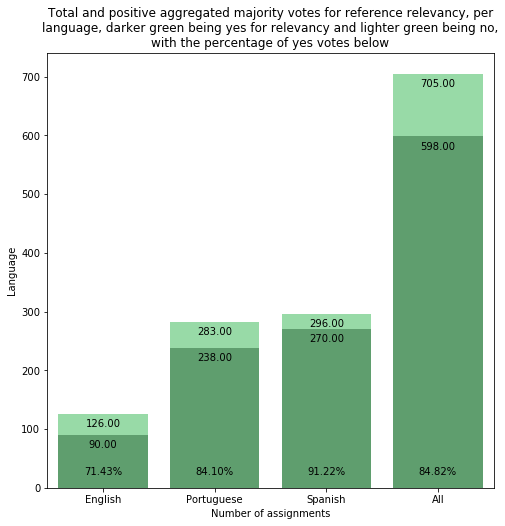

In [32]:
fig, ax = plt.subplots(figsize=(8,8))

answers_rel_language_is_present = is_present[['language','majority']]\
            .groupby(['language'])\
            .sum()\
            .join(is_present['language'].value_counts())
answers_rel_language_is_present.columns = ['is_present','total']
answers_rel_language_is_present['per'] =\
    answers_rel_language_is_present.apply(lambda x: 100*x['is_present']/x['total'], axis=1)
answers_rel_language_is_present = answers_rel_language_is_present.reset_index()

answers_rel_language_is_present = answers_rel_language_is_present.append(
    {
        'language':'All',
         'is_present': answers_rel_language_is_present['is_present'].sum(),
        'total': answers_rel_language_is_present['total'].sum(),
        'per': 100*answers_rel_language_is_present['is_present'].sum()/answers_rel_language_is_present['total'].sum()
    }, ignore_index=True
)

sns.set_color_codes("pastel")
g = sns.barplot(x="language", y="total",
            data=answers_rel_language_is_present,
            color="g", ax=ax)

sns.set_color_codes("deep")
g = sns.barplot(x="language", y="is_present",
            data=answers_rel_language_is_present,
            color="g", ax=ax)

for i, p in enumerate(g.patches):
    height = p.get_height()
    width = p.get_width()
    g.text(i%4,
            height-22,
            '{:1.2f}'.format(height),
            ha="center")
for i in range(4):
    g.text(i,
            22,
            '{:1.2f}%'.format(answers_rel_language_is_present.loc[i,'per']),
            ha="center")

ax.set(title='Total and positive aggregated majority votes for reference relevancy, per\nlanguage, darker green being yes for relevancy and lighter green being no,\nwith the percentage of yes votes below',
       ylabel='Language', xlabel = 'Number of assignments')

plt.show()

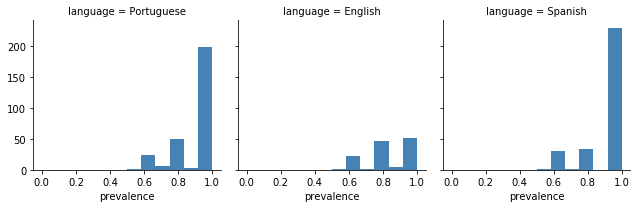

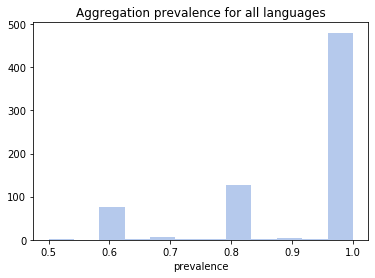

In [33]:
g = sns.FacetGrid(is_present, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(is_present['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

### accessibility / difficulty

In [34]:
is_present_reference_id_list = is_present[is_present['majority'] == 1]['reference_id'].unique().tolist()

difficulty = answers_rel_worker_outputs_df[answers_rel_worker_outputs_df['reference_id']\
    .apply(lambda x : x in is_present_reference_id_list)]\
    [['reference_id','language','difficulty']].copy()
difficulty['difficulty'] = difficulty['difficulty'].apply(lambda x : [x])
difficulty = difficulty.groupby(['reference_id','language']).sum()
difficulty['majority'] = difficulty['difficulty'].apply(majority)
difficulty['prevalence'] = difficulty.apply(lambda x : prevalence(x['difficulty'], x['majority']), axis=1)
difficulty['mean'] = difficulty['difficulty'].apply(lambda x : agg_valids(x,np.mean))
difficulty = difficulty.reset_index()
difficulty

,reference_id,language,difficulty,majority,prevalence,mean
0,004e543cc95d57af164329110bbd6414b2625685,Portuguese,"[2, 4, 3, 4, 4]",4,0.6,3.40
1,014ff1bd53b175ff82561ecf77d4bf73cb0145c4,English,"[4, 3, 3, 3, 4]",3,0.6,3.40
2,019694aaec12609e372d37a3faa5e98959c29eef,Portuguese,"[3, 4, 4, 3, 4]",4,0.6,3.60
3,01fcea45002ac4efce9ae5f0ca256c617a1f9912,Portuguese,"[3, 3, 4, 4, 3]",3,0.6,3.40
4,0278a86f541ed5fc33c93c9fc45512b74252127d,Spanish,"[4, 4, 4, 4, 4]",4,1.0,4.00
...,...,...,...,...,...,...
593,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,"[-1, 4, 3, 4, 3]",4,0.4,3.50
594,fe230de986c107e32103789cd6b65de1061e1021,Spanish,"[2, 0, 2, 4, 0]",2,0.4,1.60
595,feac85535a2bc83037727cfaa3c3b3b5dca7df6f,Portuguese,"[4, 3, -1, 4, 2]",4,0.4,3.25
596,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,English,"[4, -1, 3, 3, 3]",3,0.6,3.25


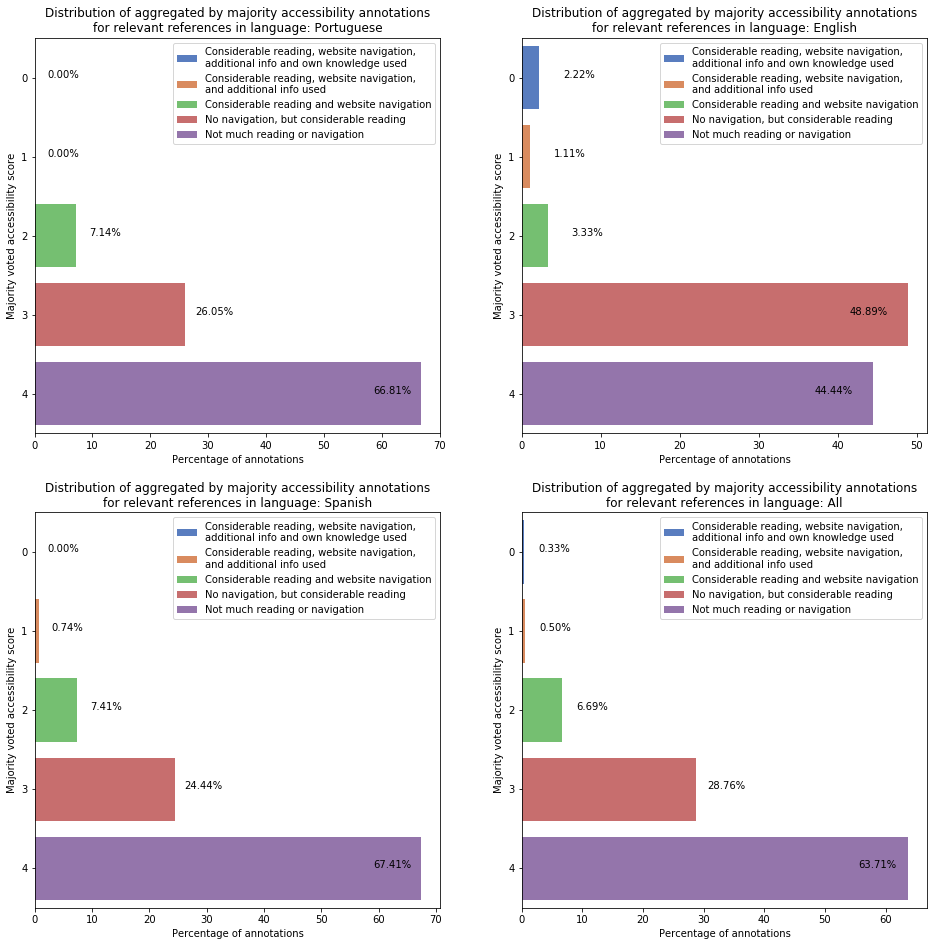

In [35]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(difficulty['language'].unique()) + ['All']):
    difficulty_lan = difficulty.copy()
    if language != 'All':
        difficulty_lan = difficulty_lan[difficulty_lan['language'] == language]
    
    difficulty_lan =\
        difficulty_lan['majority'].value_counts().reset_index()
    difficulty_lan['per'] =\
        100*difficulty_lan['majority']/sum(difficulty_lan['majority'])
    
    for j in range(5):
        if j not in difficulty_lan['index'].values:
            difficulty_lan = difficulty_lan.append(
                {'index':j,'majority':0,'per':0}, ignore_index=True
            )
    
    g = sns.barplot(
        data = difficulty_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of aggregated by majority accessibility annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Majority voted accessibility score'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Considerable reading, website navigation,\nadditional info and own knowledge used',
        'Considerable reading, website navigation,\nand additional info used',
        'Considerable reading and website navigation',
        'No navigation, but considerable reading',
        'Not much reading or navigation'
    ])

plt.show()

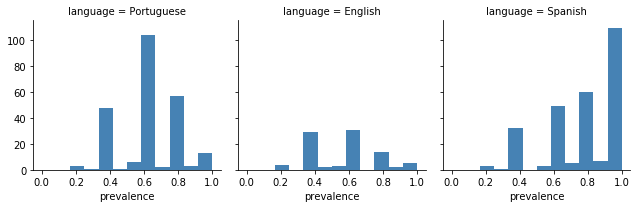

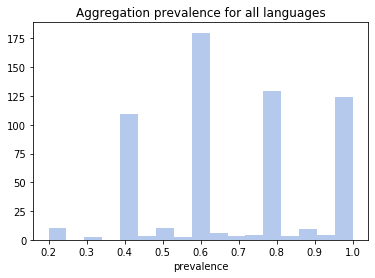

In [36]:
g = sns.FacetGrid(difficulty, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(difficulty['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

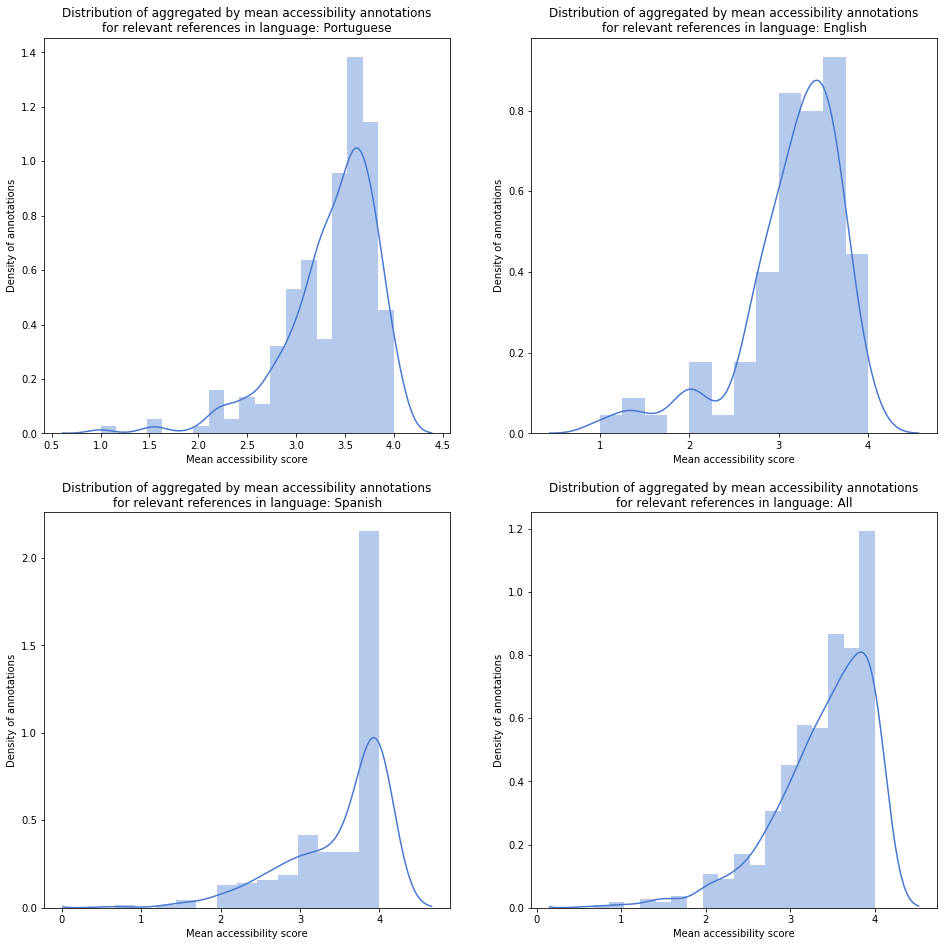

In [37]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(difficulty['language'].unique()) + ['All']):
    difficulty_lan = difficulty.copy()
    if language != 'All':
        difficulty_lan = difficulty_lan[difficulty_lan['language'] == language]
    
    g = sns.distplot(
        difficulty_lan['mean'],
        ax = ax[i//2,i%2]
    )
    
   
    ax[i//2,i%2].set(
        title='Distribution of aggregated by mean accessibility annotations\nfor relevant references in language: {}'.format(language),
        ylabel = 'Density of annotations',
        xlabel = 'Mean accessibility score'
    )

plt.show()

### reason

In [38]:
is_not_present_reference_id_list = is_present[is_present['majority'] == 0]['reference_id'].unique().tolist()

reason = answers_rel_worker_outputs_df[answers_rel_worker_outputs_df['reference_id']\
    .apply(lambda x : x in is_not_present_reference_id_list)]\
    [['reference_id','language','reason']].copy()
reason['reason'] = reason['reason'].apply(lambda x : [x])
reason = reason.groupby(['reference_id','language']).sum()
reason['majority'] = reason['reason'].apply(majority)
reason['prevalence'] = reason.apply(lambda x : prevalence(x['reason'], x['majority']), axis=1)
reason = reason.reset_index()
reason

,reference_id,language,reason,majority,prevalence
0,026721e206492badf437ebce85009d695a24eb7a,Spanish,"[6, 6, 6, -1, 6]",6,0.800000
1,072052983b1bac428de0a530349367786bc9a4f7,English,"[-1, 0, -1, 0, 1]",0,0.400000
2,09dbb927875cb45ddd8aeb88ece3b389743ecccd,Portuguese,"[-1, 0, 5, 6, -1]",0,0.200000
3,0b03bdc1eb4fa14956d6308ed4786d75078e9908,Spanish,"[5, 6, -1, -1, 0]",5,0.200000
4,106b32c820a67de0901f3bc5fac1133aba2d923c,Portuguese,"[5, 6, 5, 5, 5]",5,0.800000
...,...,...,...,...,...
102,eca613aa03a5fdac0e53a4b17ab501bc2a6c7932,Portuguese,"[0, 5, 6, 5, -1]",5,0.400000
103,ecfcd3852e80582133a35ee433a81120a6c6aa4a,Spanish,"[5, 0, 0, 0, 0]",0,0.800000
104,edcf6235a9c5e781bf68a9b9e6c7dd420b324eb7,Spanish,"[6, -1, 6, 6, -1]",6,0.600000
105,f5b2bbb4fc1b6a3e7ee1ac333cf0e716db9cdf15,Portuguese,"[5, 6, 1, -1, -1]",5,0.200000


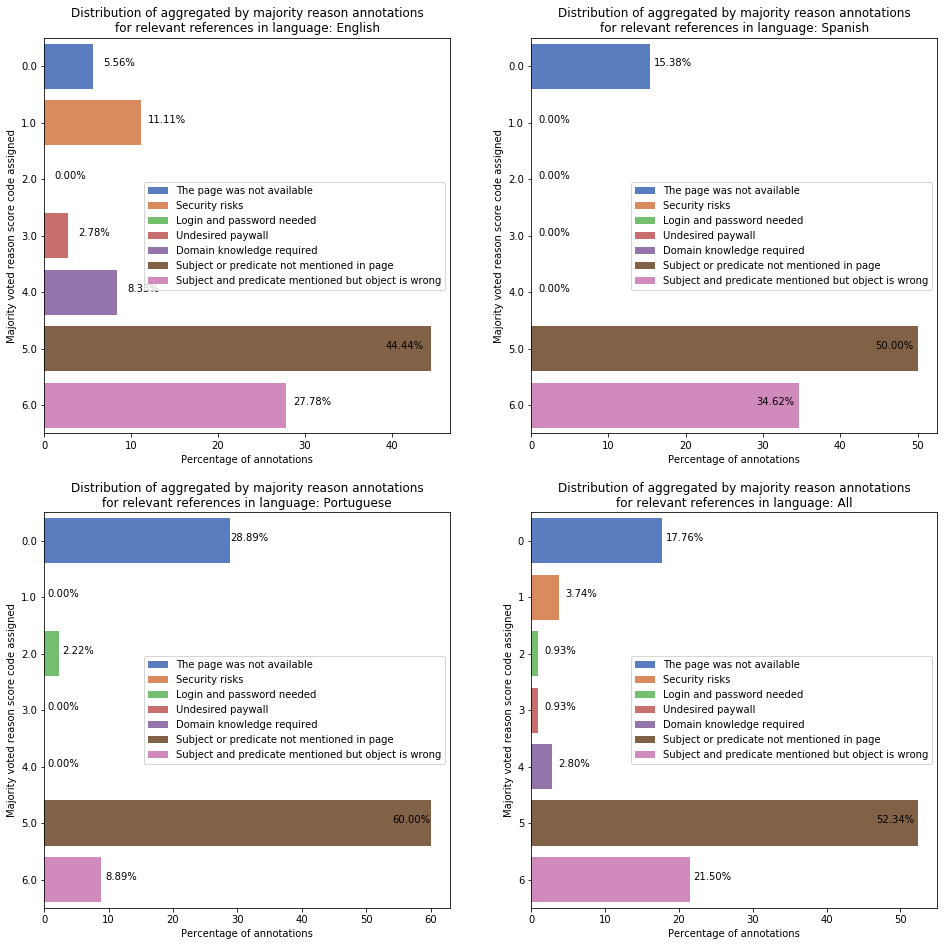

In [39]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_rel_df['language'].unique()) + ['All']):
    reason_lan = reason.copy()
    if language != 'All':
        reason_lan = reason_lan[reason_lan['language'] == language]
        
    reason_lan =\
        reason_lan['majority'].value_counts().reset_index()
    reason_lan['per'] =\
        100*reason_lan['majority']/sum(reason_lan['majority'])
 
    for j in range(7):
        if j not in reason_lan['index'].values:
            reason_lan = reason_lan.append(
                {'index':j,'reason':0,'per':0}, ignore_index=True
            )

    g = sns.barplot(
        data = reason_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    annotate_barplot(g, pad_x = 3, middle = 30, perc=True)    
    ax[i//2,i%2].set(
        title='Distribution of aggregated by majority reason annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Majority voted reason score code assigned'
    )
    
    ax[i//2,i%2].legend(
        handles=ax[i//2,i%2].patches,
        labels=[
            'The page was not available',
            'Security risks',
            'Login and password needed',
            'Undesired paywall',
            'Domain knowledge required',
            'Subject or predicate not mentioned in page',
            'Subject and predicate mentioned but object is wrong'
        ],
        loc = 'best' if i != 0 else 'center right'
    )

plt.show()

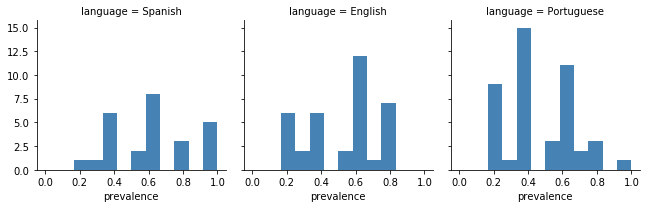

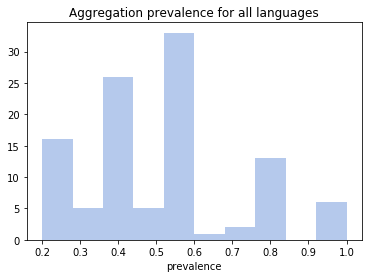

In [40]:
g = sns.FacetGrid(reason, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(reason['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

# Authoritativeness results analysis

In [41]:
answers_auth_df.head()

,task_id,batch_id,type,language,timestamp,taskSet_id,worker_id,reference_id,g_id,outputs,time,author,publisher,sub_publisher
1914,363A7XIFW7YH2YNT2XMGDY266LOAV5,f92ecdd2-e071-4863-81f2-dbcd54174303,authorit,English,2020-06-15 21:35:42.174,6acbd3b4-6e83-454b-957c-517a483aa59c,A1A6UVH1CCP8CD,5218ff0ef5205fdce63800835aaf9e91baec9134,False,"{'author': 1, 'publisher': 0, 'sub_publisher': 0}",31.329,1,0,0
1915,363A7XIFW7YH2YNT2XMGDY266LOAV5,f92ecdd2-e071-4863-81f2-dbcd54174303,authorit,English,2020-06-15 21:35:42.174,6acbd3b4-6e83-454b-957c-517a483aa59c,A1A6UVH1CCP8CD,e8b7e2dfccbf0557e781e44f31ff5c4105218b4d,False,"{'author': 1, 'publisher': 0, 'sub_publisher': 0}",27.934,1,0,0
1916,363A7XIFW7YH2YNT2XMGDY266LOAV5,f92ecdd2-e071-4863-81f2-dbcd54174303,authorit,English,2020-06-15 21:35:42.174,6acbd3b4-6e83-454b-957c-517a483aa59c,A1A6UVH1CCP8CD,cd7878c3348ebce199545479a572bd69e1a54073,False,"{'author': 1, 'publisher': 0, 'sub_publisher': 0}",15.310,1,0,0
1917,363A7XIFW7YH2YNT2XMGDY266LOAV5,f92ecdd2-e071-4863-81f2-dbcd54174303,authorit,English,2020-06-15 21:35:42.174,6acbd3b4-6e83-454b-957c-517a483aa59c,A1A6UVH1CCP8CD,a4e7281c6909b7cb2dc251f84627a41204abe07e,True,"{'author': 1, 'publisher': 1, 'sub_publisher': 2}",55.164,1,1,2
1918,363A7XIFW7YH2YNT2XMGDY266LOAV5,f92ecdd2-e071-4863-81f2-dbcd54174303,authorit,English,2020-06-15 21:35:42.174,6acbd3b4-6e83-454b-957c-517a483aa59c,A1A6UVH1CCP8CD,e316ee0eacfeed0dabe13b2ca5eca145f5dd156f,True,"{'author': 3, 'publisher': 5, 'sub_publisher':...",15.676,3,5,-1


## Distribution of annotations (not aggregated)

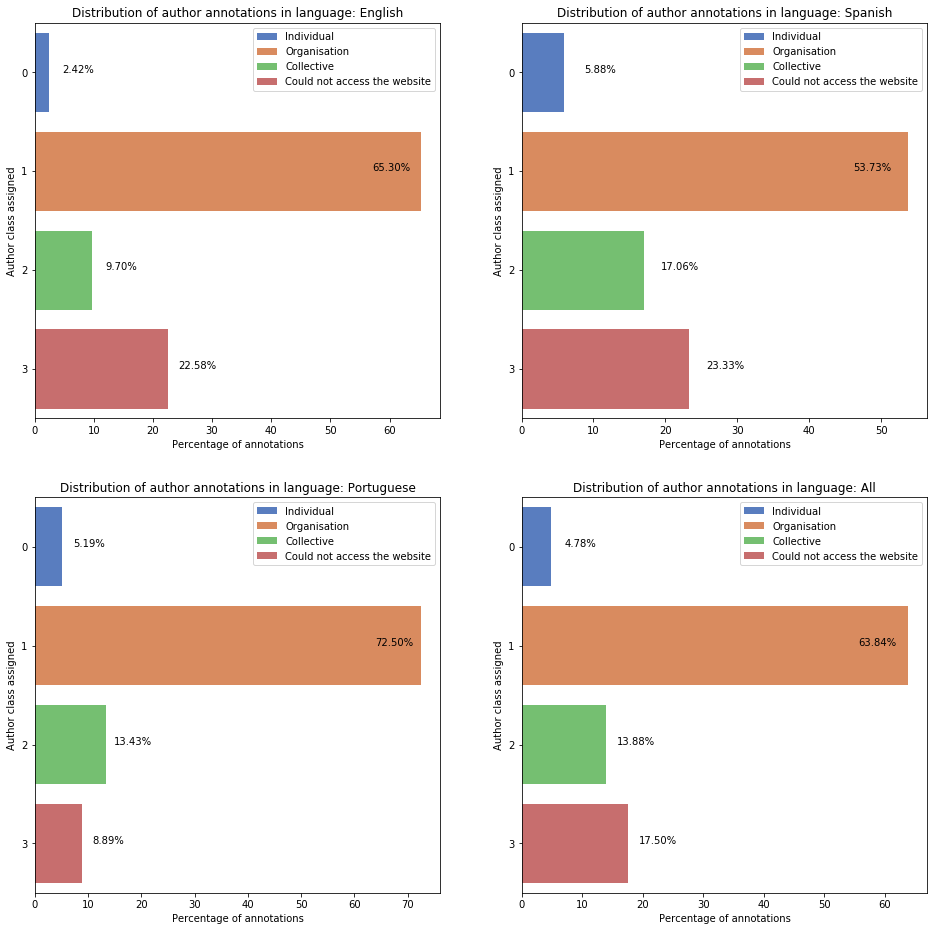

In [42]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_auth_df['language'].unique()) + ['All']):
    answers_auth_df_lan = answers_auth_df.copy()
    if language != 'All':
        answers_auth_df_lan = answers_auth_df_lan[answers_auth_df_lan['language'] == language]
    
    answers_auth_df_lan_author =\
        answers_auth_df_lan['author'].value_counts().reset_index()
    answers_auth_df_lan_author['per'] =\
        100*answers_auth_df_lan_author['author']/sum(answers_auth_df_lan_author['author'])

    g = sns.barplot(
        data = answers_auth_df_lan_author,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of author annotations in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Author class assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Individual',
        'Organisation',
        'Collective',
        'Could not access the website',
    ])

plt.show()

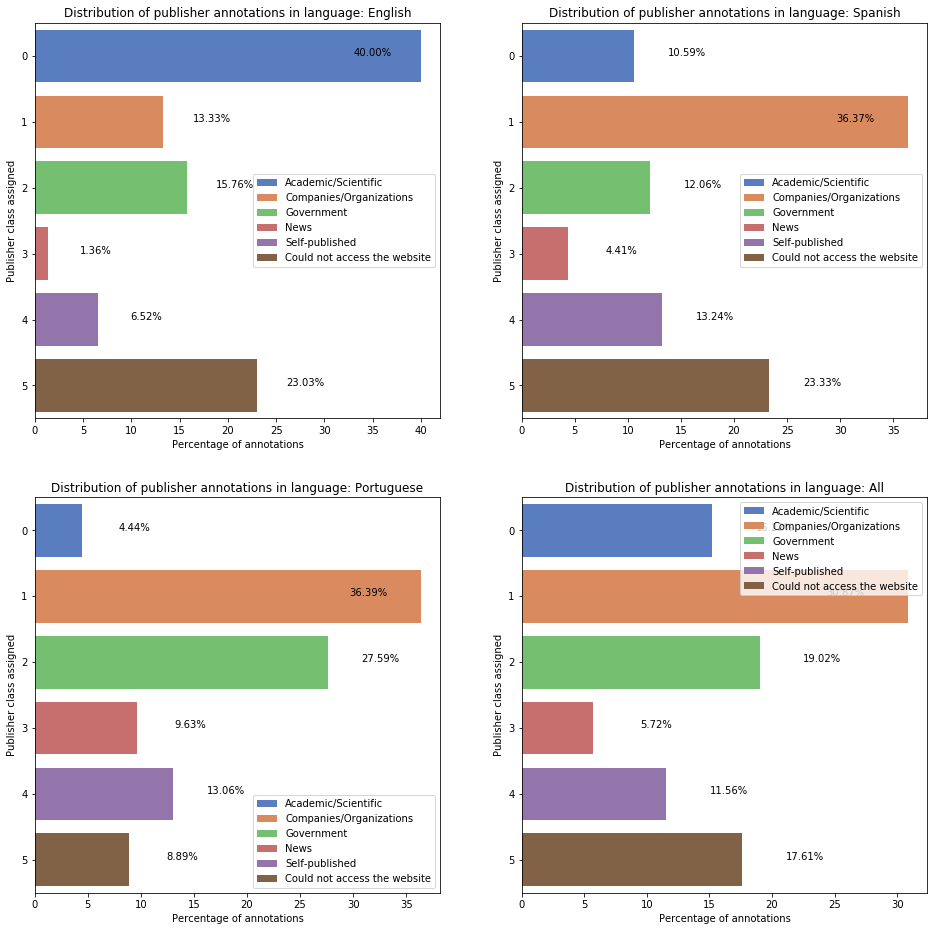

In [43]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_auth_df['language'].unique()) + ['All']):
    answers_auth_df_lan = answers_auth_df.copy()
    if language != 'All':
        answers_auth_df_lan = answers_auth_df_lan[answers_auth_df_lan['language'] == language]
    
    answers_auth_df_lan_pub =\
        answers_auth_df_lan['publisher'].value_counts().reset_index()
    answers_auth_df_lan_pub['per'] =\
        100*answers_auth_df_lan_pub['publisher']/sum(answers_auth_df_lan_pub['publisher'])

    g = sns.barplot(
        data = answers_auth_df_lan_pub,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of publisher annotations in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Publisher class assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Academic/Scientific',
        'Companies/Organizations',
        'Government',
        'News',
        'Self-published',
        'Could not access the website',
    ])

plt.show()

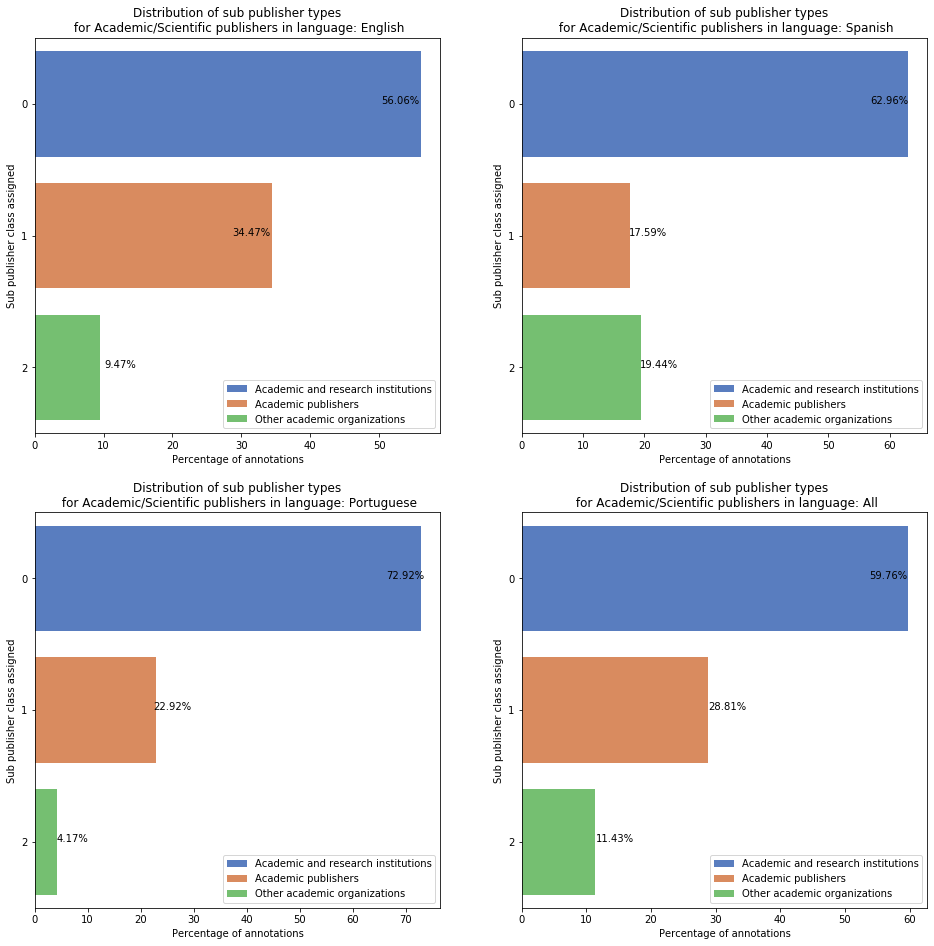

In [44]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_auth_df['language'].unique()) + ['All']):
    answers_auth_df_lan = answers_auth_df.copy()
    if language != 'All':
        answers_auth_df_lan = answers_auth_df_lan[answers_auth_df_lan['language'] == language]
    
    answers_auth_df_lan =\
        answers_auth_df_lan[answers_auth_df_lan['publisher'] == 0]['sub_publisher'].value_counts().reset_index()
    answers_auth_df_lan['per'] =\
        100*answers_auth_df_lan['sub_publisher']/sum(answers_auth_df_lan['sub_publisher'])

    g = sns.barplot(
        data = answers_auth_df_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 3, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of sub publisher types\n for Academic/Scientific publishers in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Sub publisher class assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Academic and research institutions',
        'Academic publishers',
        'Other academic organizations'
    ])

plt.show()

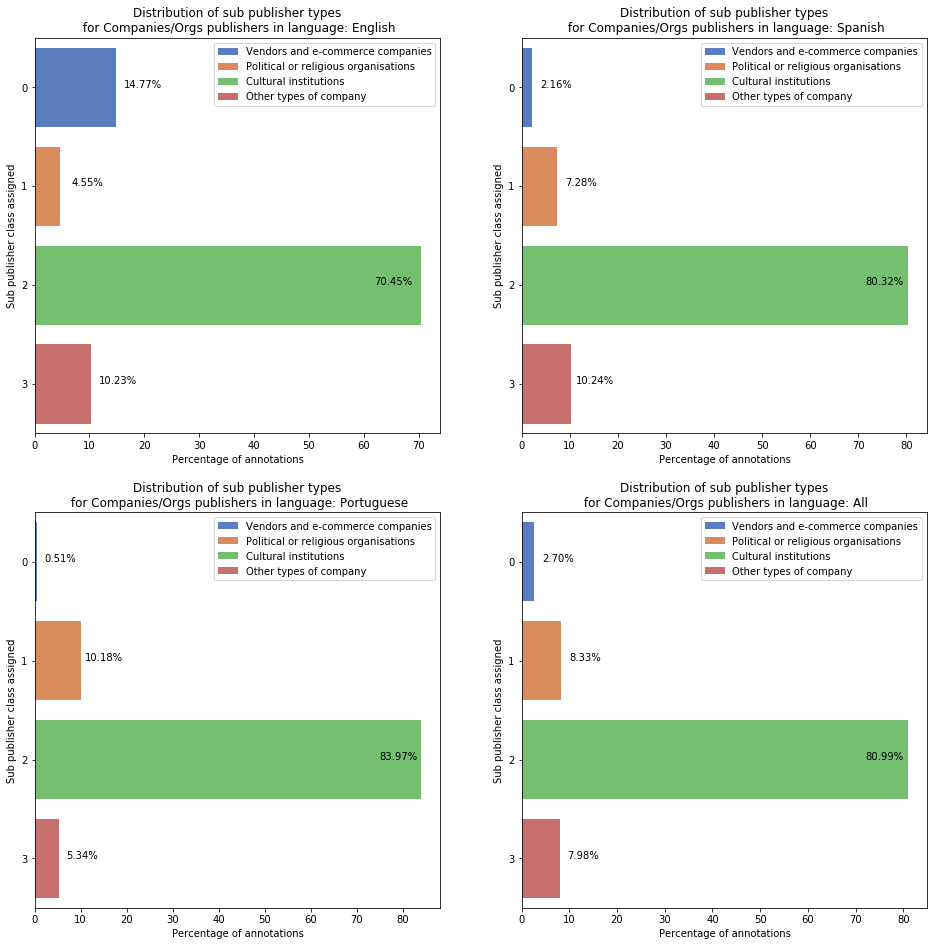

In [45]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_auth_df['language'].unique()) + ['All']):
    answers_auth_df_lan = answers_auth_df.copy()
    if language != 'All':
        answers_auth_df_lan = answers_auth_df_lan[answers_auth_df_lan['language'] == language]
    
    answers_auth_df_lan =\
        answers_auth_df_lan[answers_auth_df_lan['publisher'] == 1]['sub_publisher'].value_counts().reset_index()
    answers_auth_df_lan['per'] =\
        100*answers_auth_df_lan['sub_publisher']/sum(answers_auth_df_lan['sub_publisher'])

    g = sns.barplot(
        data = answers_auth_df_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of sub publisher types\n for Companies/Orgs publishers in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Sub publisher class assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Vendors and e-commerce companies',
        'Political or religious organisations',
        'Cultural institutions',
        'Other types of company'
    ])

plt.show()

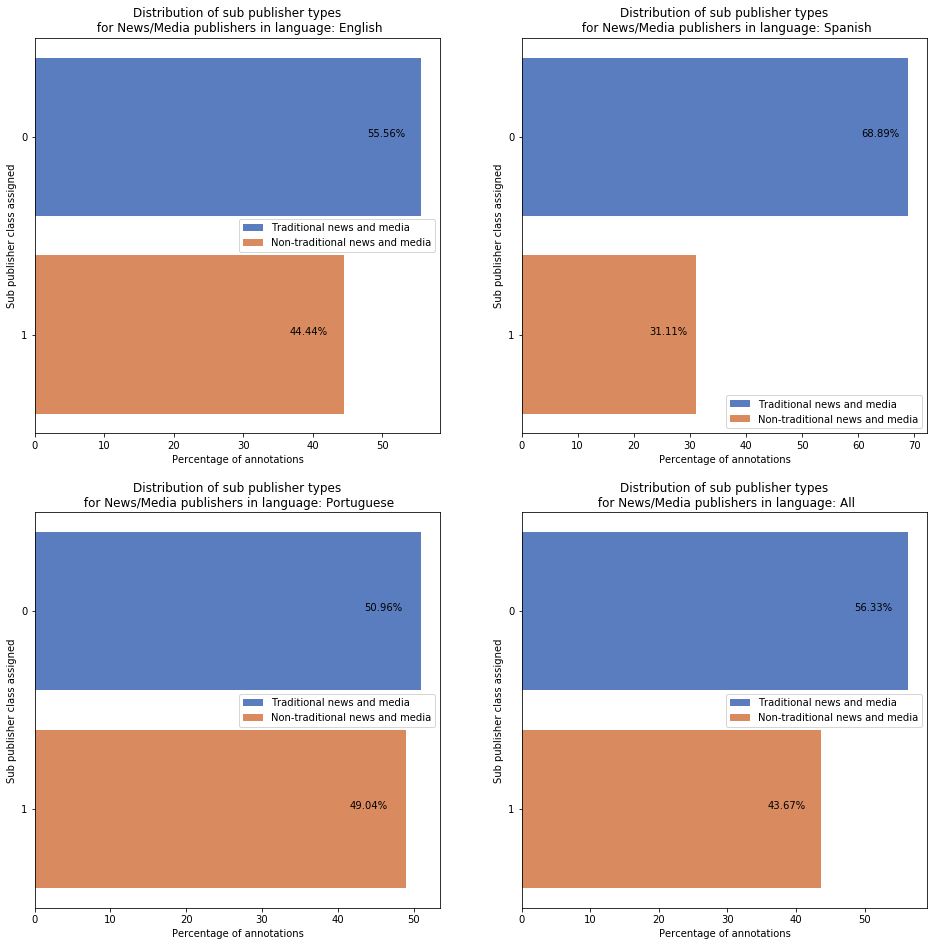

In [46]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(answers_auth_df['language'].unique()) + ['All']):
    answers_auth_df_lan = answers_auth_df.copy()
    if language != 'All':
        answers_auth_df_lan = answers_auth_df_lan[answers_auth_df_lan['language'] == language]
    
    answers_auth_df_lan =\
        answers_auth_df_lan[answers_auth_df_lan['publisher'] == 3]['sub_publisher'].value_counts().reset_index()
    answers_auth_df_lan['per'] =\
        100*answers_auth_df_lan['sub_publisher']/sum(answers_auth_df_lan['sub_publisher'])

    g = sns.barplot(
        data = answers_auth_df_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )

    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of sub publisher types\n for News/Media publishers in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Sub publisher class assigned'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Traditional news and media',
        'Non-traditional news and media'
    ])

plt.show()

## Annotator agreement levels

In [47]:
aggr_levels_authorit = {}

### author

We check on workers who gave different votes for the same reference (which tends to happen to golden standard or to tasks that were caught by the same worker if they were relaunched (very few cases). This happens, as mentioned, because as they do it again they may be doing _better_ , as they have done multiple tasks and have experience, or _worse_ , if they are tired or grew uninterested or are doing the work a bit mindlesly.

That accounts for **0.69%** of assignments.

This is probably due to low-quality workers, and is a negligeable portion of the data.

As this is nominal data, we can use **Kripp** and an **Kappas**

In [48]:
repeated_author = answers_auth_df[['worker_id','reference_id','author']].drop_duplicates().reset_index(drop=True)
repeated_author['author'] = repeated_author['author'].apply(lambda x : [x])
repeated_author = repeated_author.groupby(['worker_id','reference_id']).sum().reset_index()
total_assignments = repeated_author.shape[0]

repeated_author = repeated_author[repeated_author['author'].apply(lambda x : len(x) > 1)]
print('Total percentage of assignments that are repeated: {:1.2f}%'.format(100*repeated_author.shape[0]/total_assignments))

repeated_author = repeated_author['author'].value_counts()
print('Frequenty of values given to repeated assignments')
print(repeated_author)
print('Total number of repeated assignments')
print(repeated_author.sum())

Total percentage of assignments that are repeated: 0.69%
Frequenty of values given to repeated assignments
[0, 1]    4
[2, 1]    4
[3, 1]    3
[1, 2]    2
[2, 0]    1
[1, 0]    1
[1, 3]    1
Name: author, dtype: int64
Total number of repeated assignments
16


In [49]:
# PUTTING REPEATED VALUES AS NEW WORKERS
answers_auth_author_df = answers_auth_df.drop(['publisher','sub_publisher'],axis=1)
answers_auth_author_df = answers_auth_author_df.sort_values(['worker_id','reference_id']).reset_index(drop=True)

answers_auth_author_withreps_df = answers_auth_author_df.copy()
past_w, past_r, j = 'None', 'None', 0
for i, r in answers_auth_author_withreps_df.iterrows():
    #print(r['worker_id'],past_w,r['reference_id'],past_r)
    if r['worker_id'] == past_w and r['reference_id'] == past_r:
        j += 1
        answers_auth_author_withreps_df.loc[i,'worker_id'] = r['worker_id']+'_'+str(j)
    else:
        past_w, past_r, j = r['worker_id'], r['reference_id'], 0

In [50]:
aggr_levels_authorit['author'] = {}
aggr_levels_authorit['author']['kalpha'] = {}

for language in list(answers_auth_author_withreps_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_auth_author_withreps_df,'author',language=language,fun=np.mean
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.nominal_metric, missing_items='*')
        aggr_levels_authorit['author']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for author in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception as e:
        print('Error {}'.format(language), e)

Krippendorff's alpha for author in language English is 0.5953341354933931
Krippendorff's alpha for author in language Portuguese is 0.6755075213127184
Krippendorff's alpha for author in language Spanish is 0.557485251429455
Krippendorff's alpha for author in language None is 0.6141536792104336


In [51]:
aggr_levels_authorit['author']['fkappa'] = {}

for language in list(answers_auth_author_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_author_withreps_df,'author',language=language
    )
    fkappa = fleiss(df_fleiss)
    aggr_levels_authorit['author']['fkappa'][language] = fkappa
    print('Fleiss\'s kappa for author in language {} is {}'.format(
        language,
        fkappa
    ))
    
# MAYBE DO NOT REPORT THESE =D

Fleiss's kappa for author in language English is 0.4867807153965787
Fleiss's kappa for author in language Portuguese is 0.33517310587054666
Fleiss's kappa for author in language Spanish is 0.46330978891682056
Fleiss's kappa for author in language None is 0.4676752173571658


In [52]:
aggr_levels_authorit['author']['rkappa'] = {}

for language in list(answers_auth_author_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_author_withreps_df,'author',language=language
    )
    rkappa = fleiss(df_fleiss, method = 'rand')
    aggr_levels_authorit['author']['rkappa'][language] = rkappa
    print('Randolph\'s kappa for author in language {} is {}'.format(
        language,
        rkappa
    ))

Randolph's kappa for author in language English is 0.665993265993266
Randolph's kappa for author in language Portuguese is 0.7675438596491229
Randolph's kappa for author in language Spanish is 0.5861471861471861
Randolph's kappa for author in language None is 0.6737448559670781


### publisher

We check on workers who gave different votes for the same reference. That accounts for **0.78%** of assignments.
This is probably due to low-quality workers, and is a negligeable portion of the data.

As this is nominal data, we can use **Kripp** and an **Kappas**

In [53]:
repeated_publishers = answers_auth_df[['worker_id','reference_id','publisher']].drop_duplicates().reset_index(drop=True)
repeated_publishers['publisher'] = repeated_publishers['publisher'].apply(lambda x : [x])
repeated_publishers = repeated_publishers.groupby(['worker_id','reference_id']).sum().reset_index()
total_assignments = repeated_publishers.shape[0]

repeated_publishers = repeated_publishers[repeated_publishers['publisher'].apply(lambda x : len(x) > 1)]
print('Total percentage of assignments that are repeated: {:1.2f}%'.format(100*repeated_publishers.shape[0]/total_assignments))

repeated_publishers = repeated_publishers['publisher'].value_counts()
print('Frequenty of values given to repeated assignments')
print(repeated_publishers)
print('Total number of repeated assignments')
print(repeated_publishers.sum())

Total percentage of assignments that are repeated: 0.78%
Frequenty of values given to repeated assignments
[2, 1]       3
[3, 1]       3
[0, 1]       2
[1, 2]       2
[5, 2]       2
[2, 0]       1
[1, 5, 2]    1
[0, 2]       1
[5, 1]       1
[4, 1]       1
[1, 4]       1
Name: publisher, dtype: int64
Total number of repeated assignments
18


In [54]:
# PUTTING REPEATED VALUES AS NEW WORKERS
answers_auth_publisher_df = answers_auth_df.drop(['author','sub_publisher'],axis=1)
answers_auth_publisher_df = answers_auth_publisher_df.sort_values(['worker_id','reference_id']).reset_index(drop=True)

answers_auth_publisher_withreps_df = answers_auth_publisher_df.copy()
past_w, past_r, j = 'None', 'None', 0
for i, r in answers_auth_publisher_withreps_df.iterrows():
    #print(r['worker_id'],past_w,r['reference_id'],past_r)
    if r['worker_id'] == past_w and r['reference_id'] == past_r:
        j += 1
        answers_auth_publisher_withreps_df.loc[i,'worker_id'] = r['worker_id']+'_'+str(j)
    else:
        past_w, past_r, j = r['worker_id'], r['reference_id'], 0

In [55]:
aggr_levels_authorit['publisher'] = {}
aggr_levels_authorit['publisher']['kalpha'] = {}

for language in list(answers_auth_publisher_withreps_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_auth_publisher_withreps_df,'publisher',language=language,fun=np.mean
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.nominal_metric, missing_items='*')
        aggr_levels_authorit['publisher']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for publisher in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception as e:
        print('Error {}'.format(language), e)

Krippendorff's alpha for publisher in language English is 0.47727621490303374
Krippendorff's alpha for publisher in language Portuguese is 0.7165734549167888
Krippendorff's alpha for publisher in language Spanish is 0.5728338852810279
Krippendorff's alpha for publisher in language None is 0.6267777030428585


In [56]:
aggr_levels_authorit['publisher']['fkappa'] = {}

for language in list(answers_auth_publisher_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_publisher_withreps_df,'publisher',language=language
    )
    fkappa = fleiss(df_fleiss)
    aggr_levels_authorit['publisher']['fkappa'][language] = fkappa
    print('Fleiss\'s kappa for publisher in language {} is {}'.format(
        language,
        fkappa
    ))

Fleiss's kappa for publisher in language English is 0.42526243341241765
Fleiss's kappa for publisher in language Portuguese is 0.6579777024137485
Fleiss's kappa for publisher in language Spanish is 0.5459309564233165
Fleiss's kappa for publisher in language None is 0.588386790041793


In [57]:
aggr_levels_authorit['publisher']['rkappa'] = {}

for language in list(answers_auth_publisher_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_publisher_withreps_df,'publisher',language=language
    )
    rkappa = fleiss(df_fleiss, method = 'rand')
    aggr_levels_authorit['publisher']['rkappa'][language] = rkappa
    print('Randolph\'s kappa for publisher in language {} is {}'.format(
        language,
        rkappa
    ))

Randolph's kappa for publisher in language English is 0.49696969696969695
Randolph's kappa for publisher in language Portuguese is 0.7142105263157895
Randolph's kappa for publisher in language Spanish is 0.5940259740259741
Randolph's kappa for publisher in language None is 0.6154074074074072


### sub_publisher

As sub publisher types make no sense on their own, we group them with the publisher type for aggregating votes.

In [58]:
answers_auth_df['long_sub_publisher'] = answers_auth_df.apply(
    lambda x : float(str(x['publisher']) + (('.' + str(x['sub_publisher'])) if x['publisher'] in [0,1,3] else '')), axis=1)
#answers_auth_df

We check on workers who gave different votes for the same reference. That accounts for **1.17%** of assignments.
This is probably due to low-quality workers, and is a negligeable portion of the data.

As this is nominal data, we can use **Kripp** and an **Kappas**

In [59]:
repeated_sub_publishers = answers_auth_df[['worker_id','reference_id','long_sub_publisher']].drop_duplicates().reset_index(drop=True)
repeated_sub_publishers['long_sub_publisher'] = repeated_sub_publishers['long_sub_publisher'].apply(lambda x : [x])
repeated_sub_publishers = repeated_sub_publishers.groupby(['worker_id','reference_id']).sum().reset_index()
total_assignments = repeated_sub_publishers.shape[0]

repeated_sub_publishers = repeated_sub_publishers[repeated_sub_publishers['long_sub_publisher'].apply(lambda x : len(x) > 1)]
print('Total percentage of assignments that are repeated: {:1.2f}%'.format(100*repeated_sub_publishers.shape[0]/total_assignments))

repeated_sub_publishers = repeated_sub_publishers['long_sub_publisher'].value_counts()
print('Frequenty of values given to repeated assignments')
print(repeated_sub_publishers)
print('Total number of repeated assignments')
print(repeated_sub_publishers.sum())

Total percentage of assignments that are repeated: 1.17%
Frequenty of values given to repeated assignments
[0.0, 0.1]         3
[1.2, 1.1]         2
[1.1, 1.2]         2
[1.2, 2.0]         2
[3.1, 1.2]         2
[5.0, 2.0]         2
[2.0, 1.2]         1
[4.0, 1.3]         1
[2.0, 1.1]         1
[0.0, 1.2]         1
[3.0, 3.1]         1
[1.2, 4.0]         1
[5.0, 1.2]         1
[0.1, 0.0]         1
[2.0, 1.0]         1
[0.2, 2.0]         1
[0.1, 1.1]         1
[3.0, 1.2]         1
[2.0, 0.0]         1
[1.1, 5.0, 2.0]    1
Name: long_sub_publisher, dtype: int64
Total number of repeated assignments
27


In [60]:
# PUTTING REPEATED VALUES AS NEW WORKERS
answers_auth_sub_publisher_df = answers_auth_df.drop(['author','publisher', 'sub_publisher'],axis=1)
answers_auth_sub_publisher_df = answers_auth_sub_publisher_df.sort_values(['worker_id','reference_id']).reset_index(drop=True)

answers_auth_sub_publisher_withreps_df = answers_auth_sub_publisher_df.copy()
past_w, past_r, j = 'None', 'None', 0
for i, r in answers_auth_sub_publisher_withreps_df.iterrows():
    #print(r['worker_id'],past_w,r['reference_id'],past_r)
    if r['worker_id'] == past_w and r['reference_id'] == past_r:
        j += 1
        answers_auth_sub_publisher_withreps_df.loc[i,'worker_id'] = r['worker_id']+'_'+str(j)
    else:
        past_w, past_r, j = r['worker_id'], r['reference_id'], 0

In [61]:
aggr_levels_authorit['sub_publisher'] = {}
aggr_levels_authorit['sub_publisher']['kalpha'] = {}

for language in list(answers_auth_sub_publisher_withreps_df['language'].unique()) + [None]:
    df_kripp = prep_for_kripp(
        answers_auth_sub_publisher_withreps_df,'long_sub_publisher',language=language,fun=np.mean
    )
    try:
        kalpha = ka.krippendorff_alpha(df_kripp.values, ka.nominal_metric, missing_items='*')
        aggr_levels_authorit['sub_publisher']['kalpha'][language] = kalpha
        print('Krippendorff\'s alpha for subpublisher in language {} is {}'.format(
            language,
            kalpha
        ))
    except Exception as e:
        print('Error {}'.format(language), e)

Krippendorff's alpha for subpublisher in language English is 0.34049285220524295
Krippendorff's alpha for subpublisher in language Portuguese is 0.6742947948322441
Krippendorff's alpha for subpublisher in language Spanish is 0.5365474108186317
Krippendorff's alpha for subpublisher in language None is 0.5560022714344004


In [62]:
aggr_levels_authorit['sub_publisher']['fkappa'] = {}

for language in list(answers_auth_sub_publisher_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_sub_publisher_withreps_df,'long_sub_publisher',language=language
    )
    fkappa = fleiss(df_fleiss)
    aggr_levels_authorit['sub_publisher']['fkappa'][language] = fkappa
    print('Fleiss\'s kappa for publisher in language {} is {}'.format(
        language,
        fkappa
    ))

Fleiss's kappa for publisher in language English is 0.2828273299857777
Fleiss's kappa for publisher in language Portuguese is 0.6106432432184624
Fleiss's kappa for publisher in language Spanish is 0.5119592499630888
Fleiss's kappa for publisher in language None is 0.5117283003531767


In [63]:
aggr_levels_authorit['sub_publisher']['rkappa'] = {}

for language in list(answers_auth_sub_publisher_withreps_df['language'].unique()) + [None]:
    df_fleiss = prep_for_fleiss(
        answers_auth_sub_publisher_withreps_df,'long_sub_publisher',language=language
    )
    fkappa = fleiss(df_fleiss, method = 'rand')
    aggr_levels_authorit['sub_publisher']['rkappa'][language] = fkappa
    print('Randolph\'s kappa for publisher in language {} is {}'.format(
        language,
        fkappa
    ))

Randolph's kappa for publisher in language English is 0.3399449035812672
Randolph's kappa for publisher in language Portuguese is 0.6791866028708133
Randolph's kappa for publisher in language Spanish is 0.5742621015348288
Randolph's kappa for publisher in language None is 0.5563636363636363


### Sumary table

In [64]:
summary_df = []
for var in aggr_levels_authorit:
    for metric in aggr_levels_authorit[var]:
        for lan in aggr_levels_authorit[var][metric]:
            summary_df.append({
                'variable': var,
                'language': 'ALL' if lan is None else lan,
                'metric': metric,
                'value': aggr_levels_authorit[var][metric][lan]
            })
summary_df = pd.DataFrame(summary_df)
summary_df = summary_df.pivot_table(index=['variable','language'], columns='metric', values='value')
summary_df

metric                      fkappa    kalpha    rkappa
variable      language                                
author        ALL         0.467675  0.614154  0.673745
              English     0.486781  0.595334  0.665993
              Portuguese  0.335173  0.675508  0.767544
              Spanish     0.463310  0.557485  0.586147
publisher     ALL         0.588387  0.626778  0.615407
              English     0.425262  0.477276  0.496970
              Portuguese  0.657978  0.716573  0.714211
              Spanish     0.545931  0.572834  0.594026
sub_publisher ALL         0.511728  0.556002  0.556364
              English     0.282827  0.340493  0.339945
              Portuguese  0.610643  0.674295  0.679187
              Spanish     0.511959  0.536547  0.574262

## Aggregate value

### author

In [65]:
author = answers_auth_df[['reference_id','language','author']].copy()
author['author'] = author['author'].apply(lambda x : [x])
author = author.groupby(['reference_id','language']).sum()
author['majority'] = author['author'].apply(majority)
author['prevalence'] = author.apply(lambda x : prevalence(x['author'], x['majority']), axis=1)
author = author.reset_index()
author

,reference_id,language,author,majority,prevalence
0,004e543cc95d57af164329110bbd6414b2625685,Portuguese,"[2, 1, 1, 1, 1]",1,0.800000
1,014ff1bd53b175ff82561ecf77d4bf73cb0145c4,English,"[1, 1, 1, 1, 1]",1,1.000000
2,019694aaec12609e372d37a3faa5e98959c29eef,Portuguese,"[1, 0, 2, 1, 2]",1,0.400000
3,0278a86f541ed5fc33c93c9fc45512b74252127d,Spanish,"[1, 1, 2, 1, 1]",1,0.800000
4,02e44f544a0cd452fddcb104475ea3acb3a461ee,Portuguese,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2]",2,0.933333
...,...,...,...,...,...
459,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,"[1, 1, 1, 1, 1]",1,1.000000
460,fe230de986c107e32103789cd6b65de1061e1021,Spanish,"[3, 3, 3, 3, 3]",3,1.000000
461,feac85535a2bc83037727cfaa3c3b3b5dca7df6f,Portuguese,"[1, 1, 2, 1, 1]",1,0.800000
462,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,English,"[1, 1, 1, 1, 1]",1,1.000000


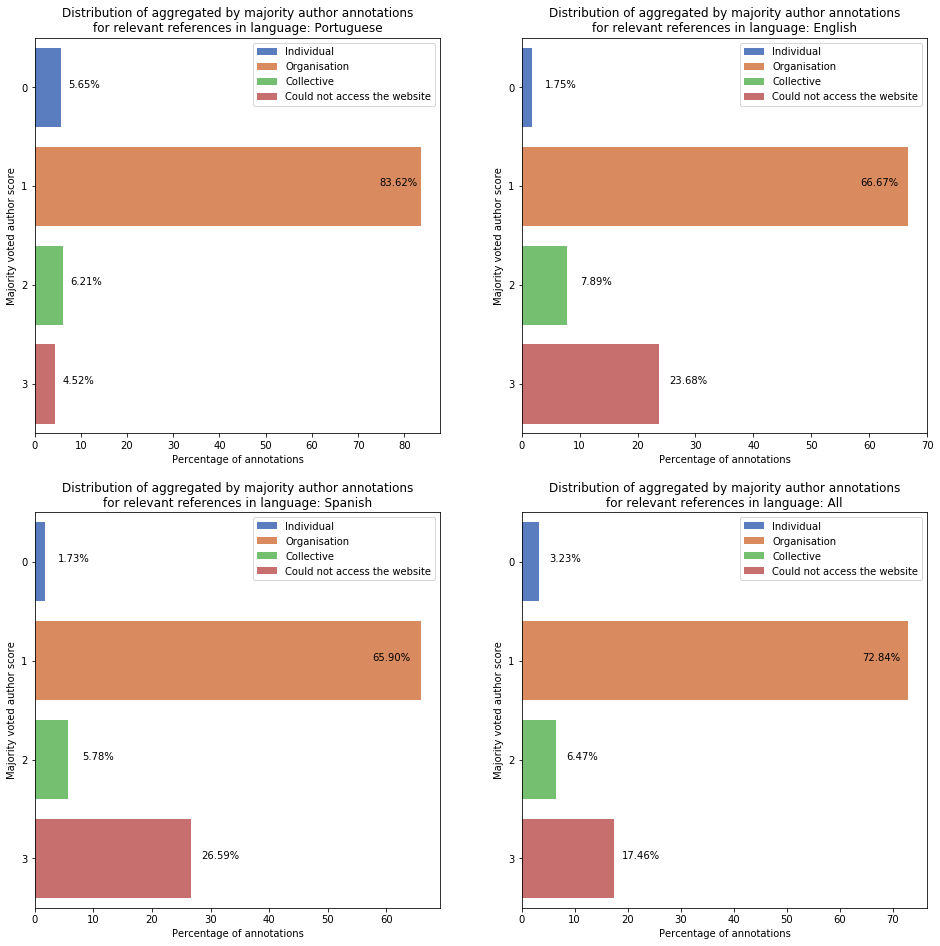

In [66]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(author['language'].unique()) + ['All']):
    author_lan = author.copy()
    if language != 'All':
        author_lan = author_lan[author_lan['language'] == language]
    
    author_lan =\
        author_lan['majority'].value_counts().reset_index()
    author_lan['per'] =\
        100*author_lan['majority']/sum(author_lan['majority'])
    
    for j in range(4):
        if j not in author_lan['index'].values:
            author_lan = author_lan.append(
                {'index':j,'majority':0,'per':0}, ignore_index=True
            )
    
    g = sns.barplot(
        data = author_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    annotate_barplot(g, pad_x = 5, middle = 30, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of aggregated by majority author annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Majority voted author score'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Individual',
        'Organisation',
        'Collective',
        'Could not access the website'
    ])

plt.show()

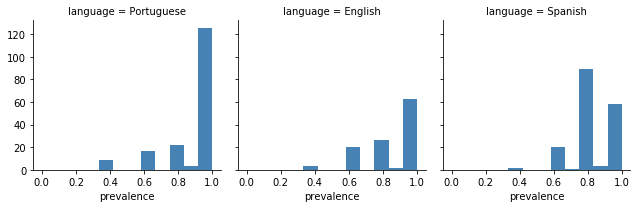

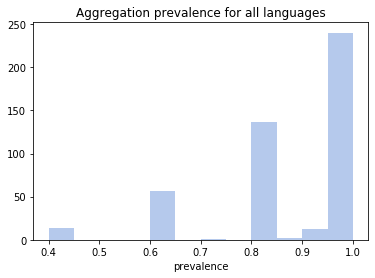

In [67]:
g = sns.FacetGrid(author, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(author['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

### publisher

In [68]:
publisher = answers_auth_df[['reference_id','language','publisher']].copy()
publisher['publisher'] = publisher['publisher'].apply(lambda x : [x])
publisher = publisher.groupby(['reference_id','language']).sum()
publisher['majority'] = publisher['publisher'].apply(majority)
publisher['prevalence'] = publisher.apply(lambda x : prevalence(x['publisher'], x['majority']), axis=1)
publisher = publisher.reset_index()
publisher

,reference_id,language,publisher,majority,prevalence
0,004e543cc95d57af164329110bbd6414b2625685,Portuguese,"[1, 2, 2, 1, 1]",1,0.600000
1,014ff1bd53b175ff82561ecf77d4bf73cb0145c4,English,"[0, 0, 0, 0, 0]",0,1.000000
2,019694aaec12609e372d37a3faa5e98959c29eef,Portuguese,"[3, 3, 4, 3, 4]",3,0.600000
3,0278a86f541ed5fc33c93c9fc45512b74252127d,Spanish,"[1, 1, 1, 1, 1]",1,1.000000
4,02e44f544a0cd452fddcb104475ea3acb3a461ee,Portuguese,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]",4,0.933333
...,...,...,...,...,...
459,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,"[1, 0, 1, 1, 1]",1,0.800000
460,fe230de986c107e32103789cd6b65de1061e1021,Spanish,"[5, 5, 5, 5, 5]",5,1.000000
461,feac85535a2bc83037727cfaa3c3b3b5dca7df6f,Portuguese,"[2, 1, 4, 1, 1]",1,0.600000
462,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,English,"[2, 0, 0, 0, 0]",0,0.800000


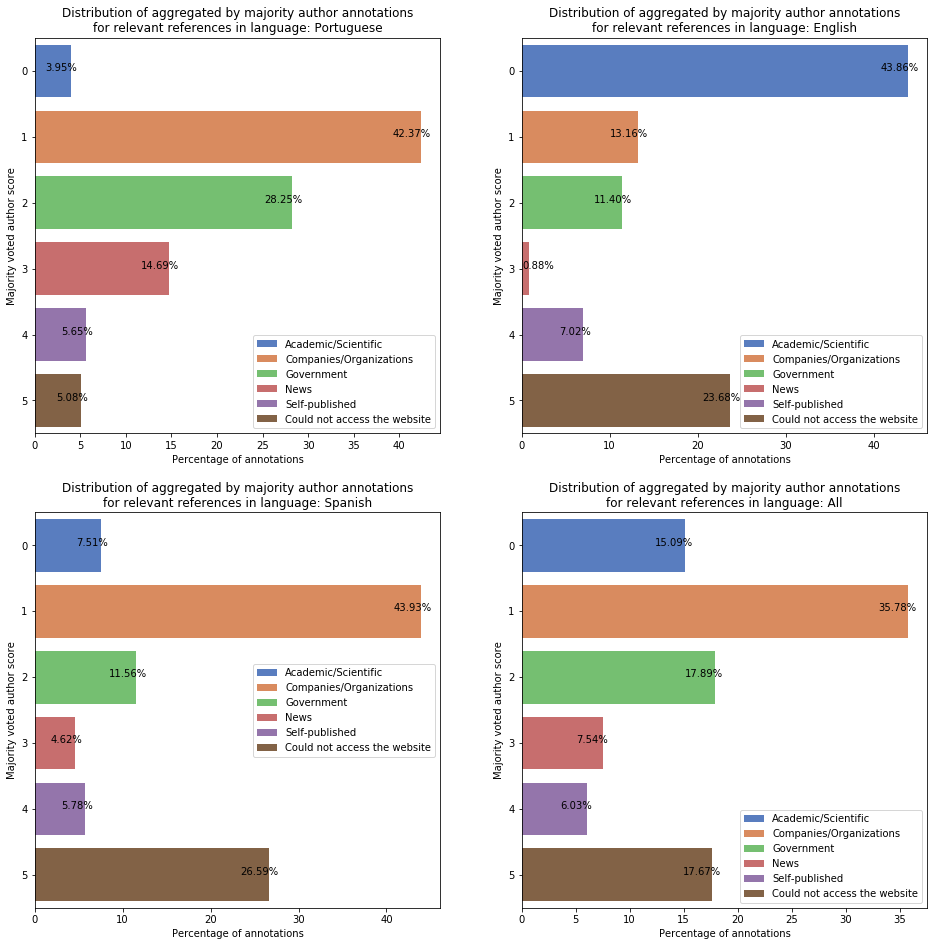

In [69]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(publisher['language'].unique()) + ['All']):
    publisher_lan = publisher.copy()
    if language != 'All':
        publisher_lan = publisher_lan[publisher_lan['language'] == language]
    
    publisher_lan =\
        publisher_lan['majority'].value_counts().reset_index()
    publisher_lan['per'] =\
        100*publisher_lan['majority']/sum(publisher_lan['majority'])
    
    for j in range(5):
        if j not in publisher_lan['index'].values:
            publisher_lan = publisher_lan.append(
                {'index':j,'majority':0,'per':0}, ignore_index=True
            )
    
    g = sns.barplot(
        data = publisher_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    annotate_barplot(g, pad_x = 1, middle = 3, perc=True)
    ax[i//2,i%2].set(
        title='Distribution of aggregated by majority author annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Majority voted author score'
    )
    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Academic/Scientific',
        'Companies/Organizations',
        'Government',
        'News',
        'Self-published',
        'Could not access the website',
    ])

plt.show()

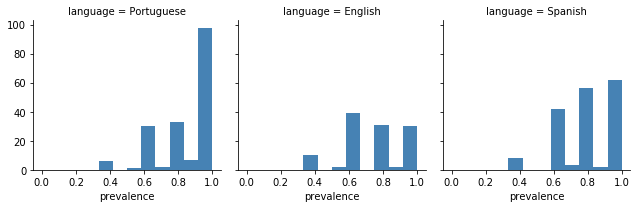

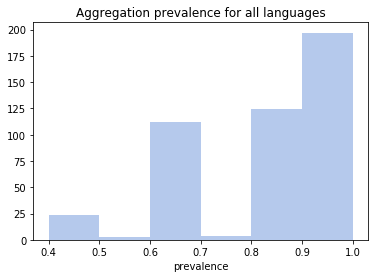

In [70]:
g = sns.FacetGrid(publisher, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(publisher['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

### sub publisher

In [71]:
def get_maj_pub(reference_id):
    return publisher[publisher['reference_id'] == reference_id]['majority'].values[0]

In [72]:
sub_publisher = answers_auth_df[['reference_id','language','long_sub_publisher']].copy()
sub_publisher['long_sub_publisher'] = sub_publisher['long_sub_publisher'].apply(lambda x : [x])
sub_publisher = sub_publisher.groupby(['reference_id','language']).sum()
sub_publisher = sub_publisher.reset_index()
# Make sure we're only getting the majority out of those scores that agree with the majority voted publisher type
sub_publisher['long_sub_publisher'] = sub_publisher.apply(lambda x : [xx for xx in x['long_sub_publisher'] if np.floor(xx) == get_maj_pub(x['reference_id'])], axis=1)
sub_publisher = sub_publisher.set_index(['reference_id','language'])
sub_publisher['majority'] = sub_publisher['long_sub_publisher'].apply(majority)
sub_publisher['prevalence'] = sub_publisher.apply(lambda x : prevalence(x['long_sub_publisher'], x['majority']), axis=1)
sub_publisher = sub_publisher.reset_index()
sub_publisher

,reference_id,language,long_sub_publisher,majority,prevalence
0,004e543cc95d57af164329110bbd6414b2625685,Portuguese,"[1.1, 1.2, 1.2]",1.2,0.666667
1,014ff1bd53b175ff82561ecf77d4bf73cb0145c4,English,"[0.2, 0.1, 0.2, 0.0, 0.2]",0.2,0.600000
2,019694aaec12609e372d37a3faa5e98959c29eef,Portuguese,"[3.1, 3.1, 3.1]",3.1,1.000000
3,0278a86f541ed5fc33c93c9fc45512b74252127d,Spanish,"[1.2, 1.2, 1.2, 1.2, 1.2]",1.2,1.000000
4,02e44f544a0cd452fddcb104475ea3acb3a461ee,Portuguese,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...",4.0,1.000000
...,...,...,...,...,...
459,fdca31ba19a072bdedaa9a03d7759db7076ebbf8,English,"[1.2, 1.2, 1.2, 1.2]",1.2,1.000000
460,fe230de986c107e32103789cd6b65de1061e1021,Spanish,"[5.0, 5.0, 5.0, 5.0, 5.0]",5.0,1.000000
461,feac85535a2bc83037727cfaa3c3b3b5dca7df6f,Portuguese,"[1.2, 1.1, 1.2]",1.2,0.666667
462,ffa9df9f0a8189d442d24b00c7b5fa8b26a03ccf,English,"[0.1, 0.1, 0.2, 0.0]",0.1,0.500000


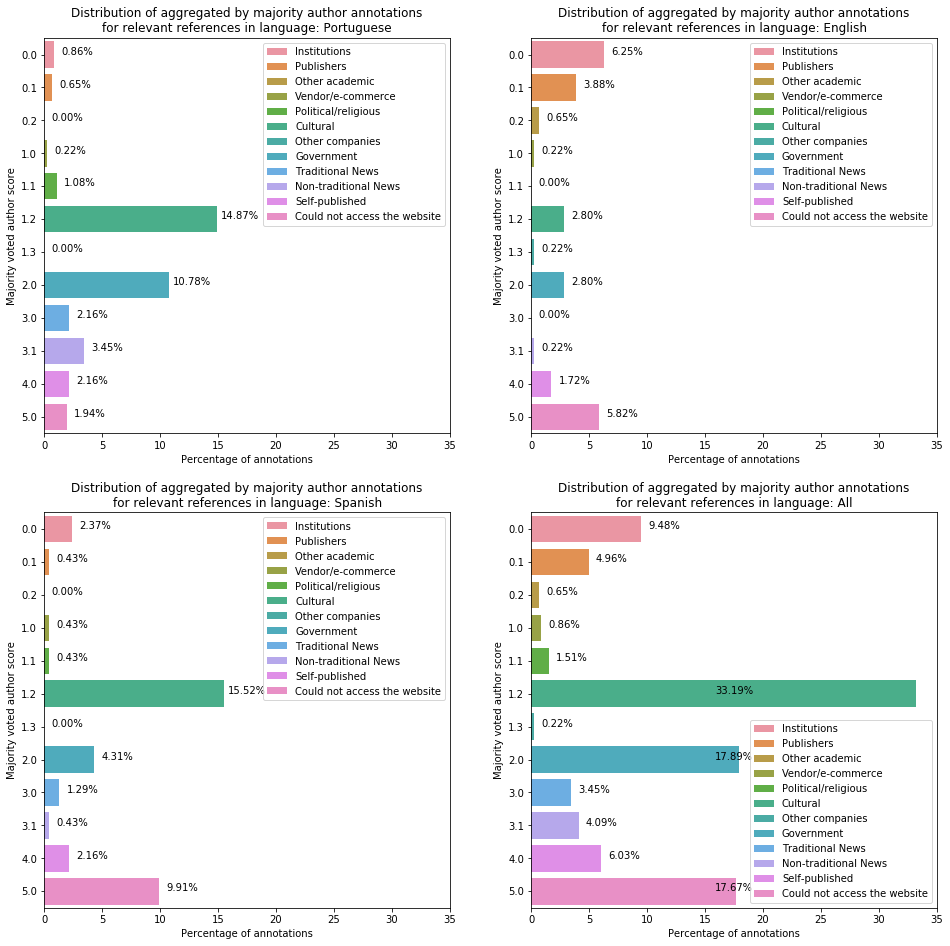

In [73]:
sns.set_palette("muted")

fig, ax = plt.subplots(2,2,figsize=(16,16))

for i, language in enumerate(list(sub_publisher['language'].unique()) + ['All']):
    sub_publisher_lan = sub_publisher.copy()
    if language != 'All':
        sub_publisher_lan = sub_publisher_lan[sub_publisher_lan['language'] == language]
    
    sub_publisher_lan =\
        sub_publisher_lan['majority'].value_counts().reset_index()
    sub_publisher_lan['per'] =\
        100*sub_publisher_lan['majority']/sum(author_lan['majority'])
    
    for j in [0.0,0.1,0.2,1.0,1.1,1.2,1.3,2.0,3.0,3.1,4.0,5.0]:
        if j not in sub_publisher_lan['index'].values:
            sub_publisher_lan = sub_publisher_lan.append(
                {'index':j,'majority':0,'per':0}, ignore_index=True
            )
    
    g = sns.barplot(
        data = sub_publisher_lan,
        y = 'index',
        x = 'per', ax = ax[i//2,i%2], orient='h'
    )
    
    ax[i//2,i%2].set_xlim([0,35])
    annotate_barplot(g, pad_x = 2, middle = 20, perc=True, limit_to_half=True)
    ax[i//2,i%2].set(
        title='Distribution of aggregated by majority author annotations\nfor relevant references in language: {}'.format(language),
        xlabel = 'Percentage of annotations',
        ylabel = 'Majority voted author score'
    )

    ax[i//2,i%2].legend(handles=ax[i//2,i%2].patches,labels=[
        'Institutions',
        'Publishers',
        'Other academic',
        'Vendor/e-commerce',
        'Political/religious',
        'Cultural',
        'Other companies',
        'Government',
        'Traditional News',
        'Non-traditional News',
        'Self-published',
        'Could not access the website',
    ])

plt.show()

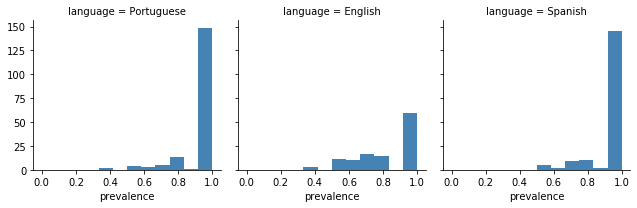

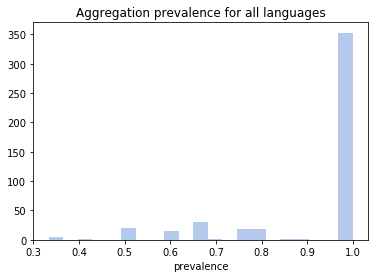

In [74]:
g = sns.FacetGrid(sub_publisher, col="language", margin_titles=True)
bins = np.linspace(0, 1, 13)
g.map(plt.hist, "prevalence", color="steelblue", bins=bins)

fig, ax = plt.subplots()
g = sns.distplot(sub_publisher['prevalence'], kde=False, ax=ax)
g.set(title='Aggregation prevalence for all languages')

plt.show()

# Generating resulting dataset

DF objects with aggregations are:

is_present,
difficulty,
reason,
author,
publisher,
sub_publisher

## English

In [75]:
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_en_rel.json') as f:
    non_gd_en_rel = json.load(f)
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_en_auth.json') as f:
    non_gd_en_auth = json.load(f)
with open('./data/final/gd_annotations/sampled_references_en_gd.json') as f:
    gd_en = json.load(f)
with open('./data/final/non_gd_annotations_auto_api/autochecked_sampled_references_en.json') as f:
    auto_en = json.load(f)

In [76]:
# REPLACE GOLD STANDARDS FOR AGGREGATED RESPONSES
for r in gd_en:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1

        r_author = author[author['reference_id'] == r['reference_id']]['majority'].values[0]
        r_publisher = publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0]
        r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
        assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
        r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        #print(e, r['url'], r['g_id'])
        if r['url'].startswith('https://www.ebi.ac.uk/europepmc/webservices/rest'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('https://api.crossref.org'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 1,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 2
              }
            }
        elif r['url'].startswith('http://purl.uniprot.org/uniprot/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 0,
                "difficulty": -1,
                "reason": 4
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 2
              }
            }
        elif r['url'].startswith('https://pubmed.ncbi.nlm.nih.gov/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('http://geonames.nga.mil/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 0,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 2,
                "sub_publisher": -1
              }
            }
        elif r['url'].startswith('https://www.ncbi.nlm.nih.gov/gene/1029626'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 4,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('https://ndclist.com/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 0,
                "difficulty": -1,
                "reason": 5
              },
              "authorit": {
                "author": 1,
                "publisher": 2,
                "sub_publisher": -1
              }
            }
        elif r['url'].startswith('https://eutils.ncbi.nlm.nih.gov/entrez/eutils'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 0,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('http://europepmc.org/abstract/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 2
              }
            }
        else:
            print(e,r)
            break
        continue

In [77]:
# Show that the auth set is a subset of the rel set, with many references removed for referencing Wikipedia
assert(all([(r in non_gd_en_rel) for r in non_gd_en_auth]))
non_gd_en = copy.deepcopy(non_gd_en_rel)

In [78]:
for r in non_gd_en:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1
        
        if '://en.wikipedia.org' in r['url']:
            r_author = 2
            r_publisher = 4
            r_sub_publisher = -1
        else:
            r_author = int(author[author['reference_id'] == r['reference_id']]['majority'].values[0])
            r_publisher = int(publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
            r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        print(e,r)
        break

In [79]:
all_en = gd_en + non_gd_en + auto_en

for r in all_en:
    assert(r['language_crawl'] == 'en')
    if r['g_id']['relevance']['is_present'] == 1:
        assert(r['g_id']['relevance']['difficulty'] != -1)
    elif r['g_id']['relevance']['is_present'] == 0:
        assert(r['g_id']['relevance']['reason'] != -1)
    if r['g_id']['authorit']['publisher'] in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] != -1)
    if r['g_id']['authorit']['publisher'] not in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] == -1)
        
assert(pd.DataFrame(all_en)['reference_id'].drop_duplicates().shape[0] == 385)
#with open('./data/final/all_aggregated_annotations/sampled_references_annotated_en_all.json','w+') as f:
#    json.dump(all_en,f, indent=2, ensure_ascii=False)

## Spanish

In [80]:
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_es_rel.json') as f:
    non_gd_es_rel = json.load(f)
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_es_auth.json') as f:
    non_gd_es_auth = json.load(f)
with open('./data/final/gd_annotations/sampled_references_es_gd.json') as f:
    gd_es = json.load(f)
with open('./data/final/non_gd_annotations_auto_api/autochecked_sampled_references_es.json') as f:
    auto_es = json.load(f)

In [81]:
# REPLACE GOLD STANDARDS FOR AGGREGATED RESPONSES
for r in gd_es:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1

        r_author = author[author['reference_id'] == r['reference_id']]['majority'].values[0]
        r_publisher = publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0]
        r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
        assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
        r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        #print(e, r['url'], r['g_id'])
        if r['url'].startswith('https://es.wikipedia.org'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 4,
                "reason": -1
              },
              "authorit": {
                "author": 2,
                "publisher": 4,
                "sub_publisher": -1
              }
            }
        elif r['url'].startswith('https://www.ebi.ac.uk/europepmc/webservices'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('https://viaf.org/viaf/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 2,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 1,
                "sub_publisher": 3
              }
            }
        elif r['url'].startswith('http://datos.bne.es/persona'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 1,
                "sub_publisher": 2
              }
            }
        elif r['url'].startswith('http://www.congreso.es/portal/page/portal/Congreso/Congreso/Iniciativas'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 2,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 2,
                "sub_publisher": -1
              }
            }
        else:
            print(e,r)
            break
        continue

In [82]:
# Show that the auth set is a subset of the rel set, with many references removed for referencing Wikipedia
assert(all([(r in non_gd_es_rel) for r in non_gd_es_auth]))
non_gd_es = copy.deepcopy(non_gd_es_rel)

In [83]:
for r in non_gd_es:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1
        
        if '://es.wikipedia.org' in r['url'] or '://en.wikipedia.org' in r['url']:
            r_author = 2
            r_publisher = 4
            r_sub_publisher = -1
        else:
            r_author = int(author[author['reference_id'] == r['reference_id']]['majority'].values[0])
            r_publisher = int(publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
            r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        print(e,r)
        break

In [84]:
all_es = gd_es + non_gd_es + auto_es

for r in all_es:
    assert(r['language_crawl'] == 'es')
    if r['g_id']['relevance']['is_present'] == 1:
        assert(r['g_id']['relevance']['difficulty'] != -1)
    elif r['g_id']['relevance']['is_present'] == 0:
        assert(r['g_id']['relevance']['reason'] != -1)
    if r['g_id']['authorit']['publisher'] in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] != -1)
    if r['g_id']['authorit']['publisher'] not in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] == -1)
        
assert(pd.DataFrame(all_es)['reference_id'].drop_duplicates().shape[0] == 385)
#with open('./data/final/all_aggregated_annotations/sampled_references_annotated_es_all.json','w+') as f:
#    json.dump(all_es,f, indent=2, ensure_ascii=False)

## Portuguese

In [85]:
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_pt_rel.json') as f:
    non_gd_pt_rel = json.load(f)
with open('./data/final/non_gd_filtered_sampled_references/filtered_sampled_references_pt_auth.json') as f:
    non_gd_pt_auth = json.load(f)
with open('./data/final/gd_annotations/sampled_references_pt_gd.json') as f:
    gd_pt = json.load(f)
with open('./data/final/non_gd_annotations_auto_api/autochecked_sampled_references_pt.json') as f:
    auto_pt = json.load(f)

In [86]:
# REPLACE GOLD STANDARDS FOR AGGREGATED RESPONSES
for r in gd_pt:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1

        r_author = author[author['reference_id'] == r['reference_id']]['majority'].values[0]
        r_publisher = publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0]
        r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
        assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
        r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        #print(e, r['url'], r['g_id'])
        if r['url'].startswith('https://pt.wikipedia.org'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 4,
                "reason": -1
              },
              "authorit": {
                "author": 2,
                "publisher": 4,
                "sub_publisher": -1
              }
            }
        elif r['url'].startswith('http://divulgacandcontas.tse.jus.br'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 4,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 2,
                "sub_publisher": -1
              }
            }
        elif r['url'].startswith('http://acervo.mp.usp.br/IconografiaV2.aspx'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 1,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 1,
                "sub_publisher": 2
              }
            }
        elif r['url'].startswith('https://www.ebi.ac.uk/europepmc/webservices'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 3,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 0
              }
            }
        elif r['url'].startswith('https://viaf.org/viaf/'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 2,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 1,
                "sub_publisher": 3
              }
            }
        elif r['url'].startswith('https://api.crossref.org'):
            r['g_id'] = {
              "relevance": {
                "is_present": 1,
                "difficulty": 1,
                "reason": -1
              },
              "authorit": {
                "author": 1,
                "publisher": 0,
                "sub_publisher": 2
              }
            }
        else:
            print(e,r)
            break
        continue

In [87]:
# Show that the auth set is a subset of the rel set, with many references removed for referencing Wikipedia
assert(all([(r in non_gd_pt_rel) for r in non_gd_pt_auth]))
non_gd_pt = copy.deepcopy(non_gd_pt_rel)

In [88]:
for r in non_gd_pt:
    try:
        r_is_present = int(is_present[is_present['reference_id'] == r['reference_id']]['majority'].values[0])
        if r_is_present == 1:
            r_difficulty = int(difficulty[difficulty['reference_id'] == r['reference_id']]['majority'].values[0])
            r_reason = -1
        elif r_is_present == 0:
            r_reason = int(reason[reason['reference_id'] == r['reference_id']]['majority'].values[0])
            r_difficulty = -1
        
        if '://pt.wikipedia.org' in r['url'] or '://en.wikipedia.org' in r['url']:
            r_author = 2
            r_publisher = 4
            r_sub_publisher = -1
        else:
            r_author = int(author[author['reference_id'] == r['reference_id']]['majority'].values[0])
            r_publisher = int(publisher[publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            r_sub_publisher = str(sub_publisher[sub_publisher['reference_id'] == r['reference_id']]['majority'].values[0])
            assert(int(r_sub_publisher.split('.')[0]) == r_publisher)
            r_sub_publisher = r_sub_publisher.split('.')[1]
        r['g_id'] = {
            'relevance': {
                'is_present': int(r_is_present),
                'difficulty': int(r_difficulty),
                'reason': int(r_reason)
            },
            'authorit': {
                'author': int(r_author),
                'publisher': int(r_publisher),
                'sub_publisher': int(r_sub_publisher if r_publisher in [0,1,3] else -1)
            }
        }
    except Exception as e:
        print(e,r)
        break

In [89]:
all_pt = gd_pt + non_gd_pt + auto_pt

for r in all_pt:
    assert(r['language_crawl'] == 'pt')
    if r['g_id']['relevance']['is_present'] == 1:
        assert(r['g_id']['relevance']['difficulty'] != -1)
    elif r['g_id']['relevance']['is_present'] == 0:
        assert(r['g_id']['relevance']['reason'] != -1)
    if r['g_id']['authorit']['publisher'] in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] != -1)
    if r['g_id']['authorit']['publisher'] not in [0,1,3]:
        assert(r['g_id']['authorit']['sub_publisher'] == -1)
        
assert(pd.DataFrame(all_pt)['reference_id'].drop_duplicates().shape[0] == 385)
#with open('./data/final/all_aggregated_annotations/sampled_references_annotated_pt_all.json','w+') as f:
#    json.dump(all_pt,f, indent=2, ensure_ascii=False)

In [91]:
print('Number of automatically checked references:')
print('English: {} / 385'.format(len(auto_en)))
print('Spanish: {} / 385'.format(len(auto_es)))
print('Portuguese: {} / 385'.format(len(auto_pt)))

Number of automatically checked references:
English: 242 / 385
Spanish: 88 / 385
Portuguese: 97 / 385


## Analysing resulting datasets

In [136]:
annotations_df

,reference_id,url,language_crawl,statement_node,subject,predicate,object,url_type,is_inferred_from,stated_in,...,wikimedia_import_urls,retrieved,publication_date,is_present,difficulty,reason,author,publisher,sub_publisher,long_sub_publisher
0,a4e7281c6909b7cb2dc251f84627a41204abe07e,https://viaf.org/viaf/64195194,en,Q7172351-D3F236F2-D920-4CF4-965E-0F33F68142A0,Pete Wylie,DNB ID,134561961,internal_url,None,Q54919,...,[],"{'time': '+2017-10-16T00:00:00Z', 'timezone': ...",None,1,3,-1,1,1,2,1.2
1,eec01187c078f8e4994ae4edd38a7e8c1a300233,https://www.ebi.ac.uk/europepmc/webservices/re...,en,Q44753358-59ACE205-1F9D-44F9-A74B-BF6FD0979EA2,An assessment of heavy metal bioaccumulation i...,PubMed ID,23666324,external_url,None,Q5412157,...,[],"{'time': '+2020-03-01T00:00:00Z', 'timezone': ...",None,1,3,-1,3,5,-1,5.0
2,5fcb9535013745aa366695b0ad4447f5cd7d3224,https://www.ebi.ac.uk/europepmc/webservices/re...,en,Q84622415-AE4E1E00-DD0C-413F-9356-DEE4A4045E35,Bottom-up optimization of SERS hot-spots,page(s),9346-9348,external_url,None,Q5412157,...,[],"{'time': '+2020-02-09T00:00:00Z', 'timezone': ...",None,1,3,-1,1,0,0,0.0
3,a10885a0cc7258364dd9f3b7cc39491d3793aa4d,https://www.ebi.ac.uk/europepmc/webservices/re...,en,Q82111771-70D99A66-3CE8-435C-BA6E-6615C847C4CA,Safety and efficacy of inhaled human insulin (...,PubMed ID,18824271,external_url,None,Q5412157,...,[],"{'time': '+2020-01-14T00:00:00Z', 'timezone': ...",None,1,3,-1,1,0,0,0.0
4,6831ccb51015d8641bff0db303fd8e21dc342c67,https://api.crossref.org/works/10.1111%2FPALA....,en,Q48109821-D3B78AF9-6CEF-4F46-BC57-E879A6FC51BA,Probabilistic methods surpass parsimony when a...,cites work,"TNT, a free program for phylogenetic analysis",external_url,None,Q5188229,...,[],"{'time': '+2018-01-21T00:00:00Z', 'timezone': ...",None,1,1,-1,1,0,2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,a760112ad9795fb33189513965256794df2f633c,https://viaf.org/viaf/122539945,pt,Q9830994-A3D18325-D2CA-47AB-9066-40A86D56FFCC,Companhia da Zambézia,identificador WorldCat Identities,viaf-122539945,internal_url,None,None,...,[],None,None,1,2,-1,1,1,3,1.3
1151,d2f4efa2190ced899dcc75f7b608cf0023122570,https://viaf.org/viaf/91373350,pt,Q1791039-A547F366-3ABD-47A3-B37A-451E2CE03320,Francisco Iglésias,identificador NTA PPN,072265205,internal_url,None,Q54919,...,[],"{'time': '+2018-08-27T00:00:00Z', 'timezone': ...",None,1,2,-1,1,1,3,1.3
1152,eb1485146eef90f60723dbc57fee15926b303759,https://api.crossref.org/works/10.1590%2FS0102...,pt,Q51144947-A631FC47-EC8D-4B0B-8BC8-AB26F8418DFB,Increase in spleen volume of rats on experimen...,cita,Experimental portal hypertension in the rat.,external_url,None,Q5188229,...,[],"{'time': '+2018-01-21T00:00:00Z', 'timezone': ...",None,1,1,-1,1,0,2,0.2
1153,7e73f61f63a799da4ad1da4f4ffd4c7fcb8404e8,https://www.ebi.ac.uk/europepmc/webservices/re...,pt,Q33848447-C285A200-BA51-4F22-AAF6-4F4C76153B02,Cytotoxic effects of the compound cis-tetraamm...,título,Cytotoxic effects of the compound cis-tetraamm...,external_url,None,Q5412157,...,[],"{'time': '+2020-03-09T00:00:00Z', 'timezone': ...",None,1,3,-1,1,0,0,0.0
